In [731]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from pandas.plotting import table
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots
import datetime

In [732]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[4], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Full': pal[3],
        'Cluster': pal[2], 'Obligate': pal[7], 'Full Depth': pal[3], 'Cluster (w/ Uniform Clstrs.)': pal[11],
        'Cluster (w/o Uniform Clstrs.)': pal[10], 'AI Cluster': pal[2], 'TD Cluster': pal[0], 'TD Full Depth': pal[1], 'AI Full Depth': pal[3],
        'AI Cluster (w/ Uniform Clstrs.)': pal[2], 'TD Cluster (w/ Uniform Clstrs.)': pal[0], 'AI Cluster (w/o Uniform Clstrs.)': pal[2],
        'TD Cluster (w/o Uniform Clstrs.)': pal[0], 'Obligate Cluster (w/ Uniform Clstrs.)': pal[6], 'Obligate Full Depth': pal[7]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [733]:
pal2 = sns.color_palette('BuGn')

gns = {'Single Conformation': pal2[2], 'Multi-Conformation': pal2[5]}
pal2.as_hex()

['#e2f4f7', '#bde6de', '#84cfb9', '#51b689', '#2c9553', '#05712f']

In [734]:
# Define the names of the categories ahead of time
im = '$_{im}$RMSD'
fd = '$_{fd}$RMSD'
imfd = '$_{fd}^{im}$RMSD'
d1 = '$_{d1}$RMSD'
d2 = '$_{d2}$RMSD'
d1d2 = '$_{d2}^{d1}$RMSD'

imd1 = '$_{im}$RMSD/$_{d1}$RMSD'
fdd2 = '$_{fd}$RMSD/$_{d2}$RMSD'
imfdd1d2 = '$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD'

In [735]:
# Load the data
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')
obli = pd.read_csv('./project_pipeline/data/obligate.tsv', sep='\t').astype('object')

cl.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,chain,af_filename
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif


In [736]:
# Reformat the data for plotting

# Add 1_aligned to classified files
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
cl = pd.merge(cl, rmsdSub, on=['uniprot', 'pdb'], how='left')

# Select columns of interest
clSub = cl[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
clSub.columns = ['Uniprot', 'PDB', 'gRMSD', im, fd, imfd]

clSub[['gRMSD', im, fd, imfd]] = clSub[['gRMSD', im, fd, imfd]].astype(float)

# Melt the data
plot = pd.melt(clSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot['RMSD'] = plot['RMSD'].astype(float)

# Remove outliers above 100 RMSD
plot = plot[plot['RMSD'] < 100]

/tmp/ipykernel_2592195/1211847273.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub[['gRMSD', im, fd, imfd]] = clSub[['gRMSD', im, fd, imfd]].astype(float)


In [737]:
# Add in multi-domain data
# Subset the data
mdSub = md[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
mdSub.columns = ['Uniprot', 'PDB', 'gRMSD', d1, d2, d1d2]

# Melt the data
mdPlot = pd.melt(mdSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
mdPlot['RMSD'] = mdPlot['RMSD'].astype(float)

In [738]:
# Add types to the dataframes
clSub['Type'] = 'Autoinhibitory'
mdSub['Type'] = 'Two-Domain'

# Rename the columns to match
clSub.columns = ['UniProt', 'PDB', 'gRMSD', imd1, fdd2, imfdd1d2, 'Type']
mdSub.columns = ['UniProt', 'PDB', 'gRMSD', imd1, fdd2, imfdd1d2, 'Type']

# Concatenate the dataframes
allPlot = pd.concat([clSub, mdSub])

# Melt the data
allPlot = pd.melt(allPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
allPlot['RMSD'] = allPlot['RMSD'].astype(float)

# Remove outliers
allPlot = allPlot[allPlot['RMSD'] < 100]
mdSub.head()

/tmp/ipykernel_2592195/1047113835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub['Type'] = 'Autoinhibitory'
/tmp/ipykernel_2592195/1047113835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdSub['Type'] = 'Two-Domain'


,UniProt,PDB,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Type
0,D9N168,3ht3,1.115,0.883,1.153,0.979,Two-Domain
1,D9N168,4o0i,1.166,0.826,1.253,0.999,Two-Domain
2,D9N168,6ueu,1.787,0.72,2.667,1.017,Two-Domain
3,D9N168,6ur2,1.208,0.836,1.317,0.998,Two-Domain
4,D9N168,6ur4,1.208,0.842,1.275,1.073,Two-Domain


/tmp/ipykernel_2592195/4012027439.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.314e-32 U_stat=1.277e+05
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.101e-28 U_stat=1.248e+05
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.430e-20 U_stat=1.180e+05
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:8.843e-21 U_stat=1.179e+05


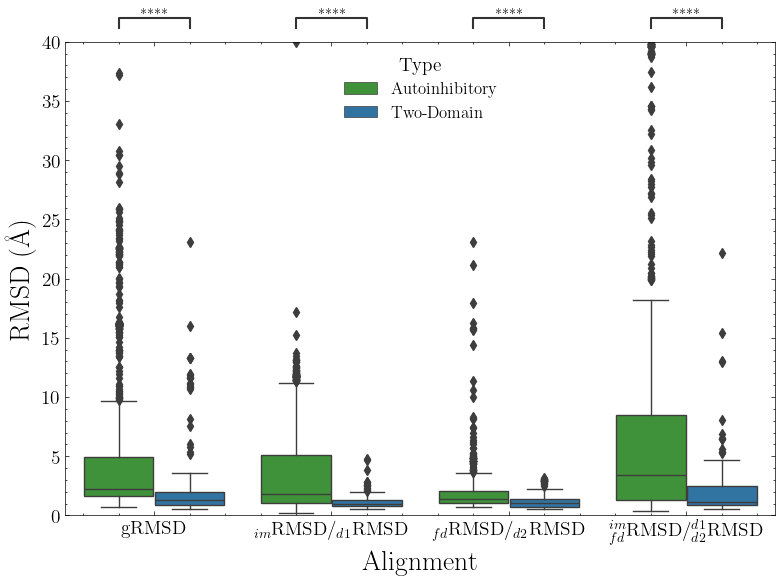

In [739]:
# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=allPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]
annotator = Annotator(ax, pairs, data=allPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_md_all_rmsd_distributions.png', dpi=500, bbox_inches='tight')

The above plot was for all of our experimental structures. How about only the best ones for each protein?

In [740]:
min_cl = clSub.groupby('UniProt')['gRMSD'].min()
minimum_cl = pd.merge(min_cl, clSub, on=['UniProt', 'gRMSD'], how='inner').drop_duplicates(subset='UniProt')

min_md = mdSub.groupby('UniProt')['gRMSD'].min()
minimum_md = pd.merge(min_md, mdSub, on=['UniProt', 'gRMSD'], how='inner').drop_duplicates(subset='UniProt')

In [741]:
minimum_cl[minimum_cl['gRMSD'] < 3].shape

(75, 7)

In [742]:
minimum_cl.describe()

,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD
count,128.000000,128.000000,128.000000,128.000000
mean,6.557945,2.900789,2.294359,13.093375
std,12.142941,4.258162,2.275397,26.957151
min,0.712000,0.344000,0.683000,0.742000
25%,1.552750,1.121000,1.140500,1.429000
50%,2.426500,1.635000,1.685000,3.310500
75%,6.725500,3.072000,2.390250,12.173750
max,113.774000,40.009000,17.946000,220.629000


In [743]:
# Turn it into plotting form
minPlot = pd.concat([minimum_cl, minimum_md])

# Melt the data
minPlot = pd.melt(minPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
minPlot['RMSD'] = minPlot['RMSD'].astype(float)

/tmp/ipykernel_2592195/2490701899.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.644e-07 U_stat=3.914e+03
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.596e-05 U_stat=3.690e+03
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.477e-08 U_stat=4.082e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.381e-03 U_stat=3.348e+03


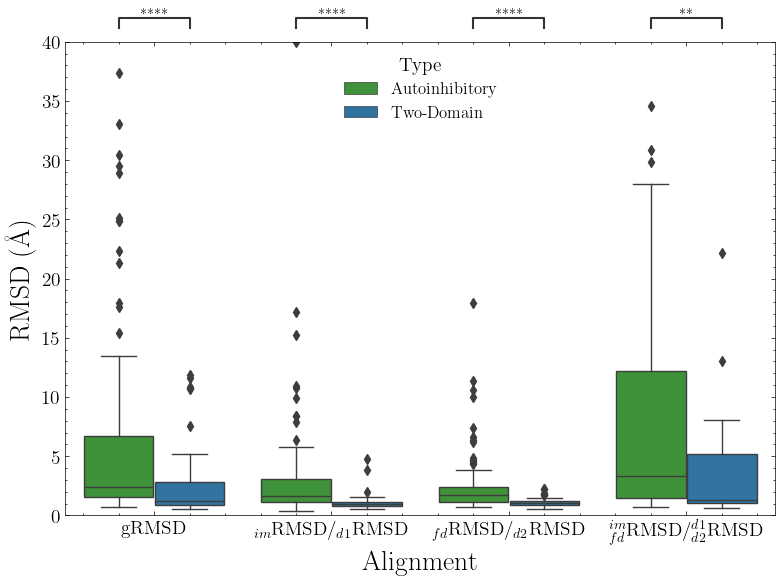

In [744]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=minPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=minPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_md_best_rmsd_distributions.png', dpi=500, bbox_inches='tight')

In [745]:
minPlot.groupby('Type')['PDB'].nunique()

Type
Autoinhibitory    128
Two-Domain         40
Name: PDB, dtype: int64

Real quick make a graph showing the correlation between imfdRMSD & the domains.

In [746]:
# Pivot the data back to the original form
pivoted = minPlot.pivot(index=['UniProt', 'PDB', 'Type'], columns='Alignment', values='RMSD').reset_index()
ai_only = pivoted[pivoted['Type'] == 'Autoinhibitory']
md_only = pivoted[pivoted['Type'] == 'Two-Domain']

In [747]:
ai_matrix = ai_only[['gRMSD', imd1, fdd2, imfdd1d2]].corr()
ai_matrix

Alignment,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD
Alignment,,,,
gRMSD,1.000000,0.355732,0.316230,0.938790
$_{im}$RMSD/$_{d1}$RMSD,0.355732,1.000000,0.268982,0.417048
$_{fd}$RMSD/$_{d2}$RMSD,0.316230,0.268982,1.000000,0.243025
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,0.938790,0.417048,0.243025,1.000000


We look at only those proteins with structured inhibitory modules. 

In [748]:
dis = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t')

dis = dis[['uniprot', 'r1_mean_plddt', 'mean_pae_1_1', 'ar_disorder', 'percent_disorder_1']].drop_duplicates()

dis_uniprots = dis[dis['ar_disorder'] == 'structured']['uniprot'].unique()
len(dis_uniprots)

dis_cl = minimum_cl[minimum_cl['UniProt'].isin(dis_uniprots)]

dis_minPlot = pd.concat([dis_cl, minimum_md])

# Melt the data
dis_minPlot = pd.melt(dis_minPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
dis_minPlot['RMSD'] = dis_minPlot['RMSD'].astype(float)

In [749]:
dis_minPlot.groupby('Type')['UniProt'].nunique()

Type
Autoinhibitory    105
Two-Domain         40
Name: UniProt, dtype: int64

/tmp/ipykernel_2592195/234789065.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.021e-05 U_stat=3.098e+03
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.460e-04 U_stat=2.959e+03
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.027e-07 U_stat=3.304e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.443e-02 U_stat=2.654e+03


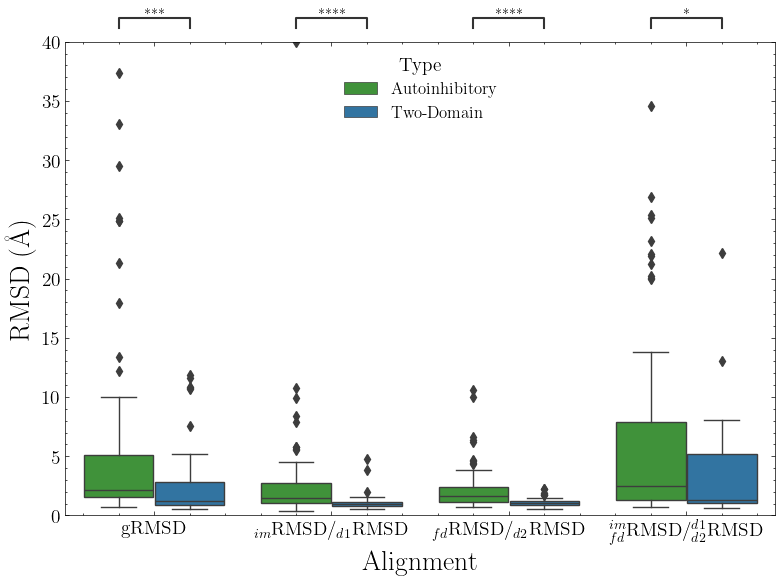

In [750]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=dis_minPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=dis_minPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/structured_im_only_rmsd.png', dpi=500, bbox_inches='tight')

How about only obligate two-domain proteins?

In [751]:
obli_uniprots = obli['uniprot'].unique()

obli_md = minimum_md[minimum_md['UniProt'].isin(obli_uniprots)]
obli_md['Type'] = 'Obligate'

obli_minPlot = pd.concat([minimum_cl, obli_md])

# Melt the data
obli_minPlot = pd.melt(obli_minPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
obli_minPlot['RMSD'] = obli_minPlot['RMSD'].astype(float)

/tmp/ipykernel_2592195/1126207313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obli_md['Type'] = 'Obligate'


In [752]:
obli_md.head()

,UniProt,gRMSD,PDB,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Type
18,O60729,0.897,1ohe,0.978,0.745,1.054,Obligate
20,O69275,1.358,2j3z,1.586,0.92,1.614,Obligate
21,P04807,1.132,1ig8,1.044,1.015,1.629,Obligate
22,P04958,0.811,5n0c,0.72,0.619,0.728,Obligate
23,P0AG30,1.275,1a62,1.041,1.287,1.239,Obligate


In [753]:
obli_md[imfdd1d2].median()

1.239

In [754]:
obli_minPlot.groupby('Type')['UniProt'].nunique()

Type
Autoinhibitory    128
Obligate            7
Name: UniProt, dtype: int64

/tmp/ipykernel_2592195/3254826063.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:1.944e-02 U_stat=6.840e+02
gRMSD_Autoinhibitory vs. gRMSD_Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:2.456e-04 U_stat=8.180e+02
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:2.758e-04 U_stat=8.150e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:3.660e-03 U_stat=7.290e+02


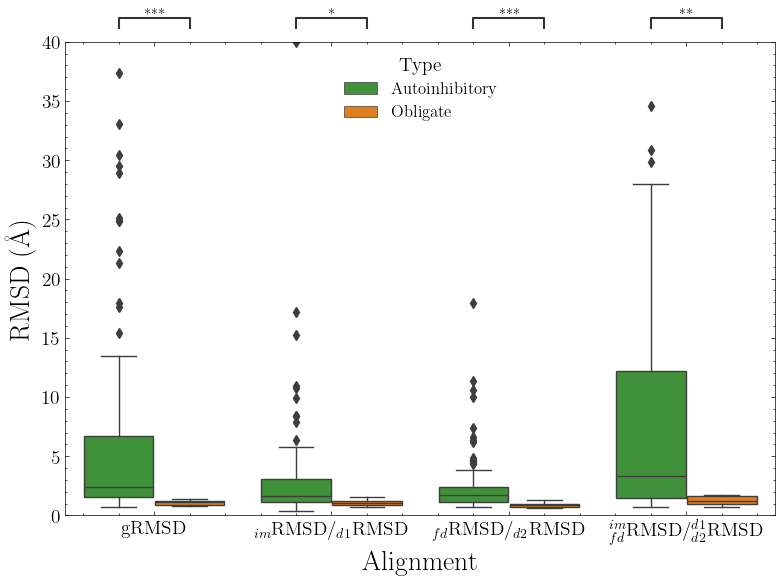

In [755]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=obli_minPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Obligate')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Obligate')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Obligate')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Obligate')]]
annotator = Annotator(ax, pairs, data=obli_minPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_obli_rmsd.png', dpi=500, bbox_inches='tight')

Next we show this for only those proteins with two distinct conformations.

In [756]:
# Find the max and min $_{im}$RMSDAE per protein and create a new dataframe with the difference between those two values
df_max = clSub.groupby('UniProt')[imfdd1d2].max().reset_index()
df_min = clSub.groupby('UniProt')[imfdd1d2].min().reset_index().drop_duplicates(keep='first')
df_diff = pd.merge(df_max, df_min, on='UniProt')
df_diff['diff'] = df_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_x'] - df_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_y']
df_diff = df_diff.sort_values('diff', ascending=False)
df_diff.head()

,UniProt,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_x,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_y,diff
107,Q96P20,80.422,6.447,73.975
62,Q00944,71.123,1.906,69.217
66,Q06124,58.638,0.770,57.868
35,P29350,57.427,1.765,55.662
5,O08967,54.034,1.593,52.441


In [757]:
# What are the state and conformation annotations for these proteins?
df_smol = df_diff[['UniProt', 'diff']]
df_max = pd.merge(clSub, df_max, on=['UniProt', imfdd1d2])
df_min = pd.merge(clSub, df_min, on=['UniProt', imfdd1d2])
bounds = pd.concat([df_max, df_min])
df = pd.merge(clSub, df_smol, on='UniProt')
g3 = pd.merge(bounds, df_smol, on='UniProt')

g3 = g3[g3['diff'] > 3]

In [758]:
g3['UniProt'].nunique()

29

In [759]:
# Take the best structure for each protein, based on $_{im}$RMSDAE
min_g3 = g3.groupby('UniProt')[imfdd1d2].min().reset_index()
min_g3 = pd.merge(min_g3, g3, on=['UniProt', imfdd1d2], how='inner').drop_duplicates(subset='UniProt')

In [760]:
rand = min_g3.rename(columns={'UniProt': 'uniprot', 'PDB': 'pdb'})
min_state = pd.merge(rand, cl, on=['uniprot', 'pdb'], how='inner')
min_state['state'].value_counts()

Active           14
Autoinhibited    10
Name: state, dtype: int64

In [761]:
match = min_state[min_state['gRMSD'] <= 3]
non_match = min_state[min_state['gRMSD'] > 3]

match['state'].value_counts()

Active           9
Autoinhibited    5
Name: state, dtype: int64

In [762]:
non_match['state'].value_counts()

Autoinhibited    5
Active           5
Name: state, dtype: int64

Repeat for multi-domain proteins

In [763]:
md_max = mdSub.groupby('UniProt')[imfdd1d2].max().reset_index()
md_min = mdSub.groupby('UniProt')[imfdd1d2].min().reset_index().drop_duplicates(keep='first')
md_diff = pd.merge(md_max, md_min, on='UniProt')
md_diff['diff'] = md_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_x'] - md_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_y']
md_diff = md_diff.sort_values('diff', ascending=False)
md_diff.head()

# What are the state and conformation annotations for these proteins?
md_smol = md_diff[['UniProt', 'diff']]
md_max = pd.merge(mdSub, md_max, on=['UniProt', imfdd1d2])
md_min = pd.merge(mdSub, md_min, on=['UniProt', imfdd1d2])
md_bounds = pd.concat([md_max, md_min])
md = pd.merge(mdSub, md_smol, on='UniProt')
md_g3 = pd.merge(md_bounds, md_smol, on='UniProt')

md_g3 = md_g3[md_g3['diff'] > 3]

In [764]:
# Take the best structure for each protein, based on $_{im}$RMSDAE
min_md_g3 = md_g3.groupby('UniProt')[imfdd1d2].min().reset_index()
min_md_g3 = pd.merge(min_md_g3, md_g3, on=['UniProt', imfdd1d2], how='inner').drop_duplicates(subset='UniProt')

In [765]:
min_md_g3['UniProt'].nunique()

6

In [766]:
ming3plot = pd.concat([min_g3, minimum_md]) # Minimum md if you want all 40 proteins
ming3plot = pd.melt(ming3plot, id_vars=['UniProt', 'PDB', 'Type', 'diff'], var_name='Alignment', value_name='RMSD')
ming3plot['RMSD'] = ming3plot['RMSD'].astype(float)

/tmp/ipykernel_2592195/2981880450.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-04 U_stat=8.710e+02
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.262e-03 U_stat=8.225e+02
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:7.783e-05 U_stat=9.055e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.891e-02 U_stat=7.425e+02


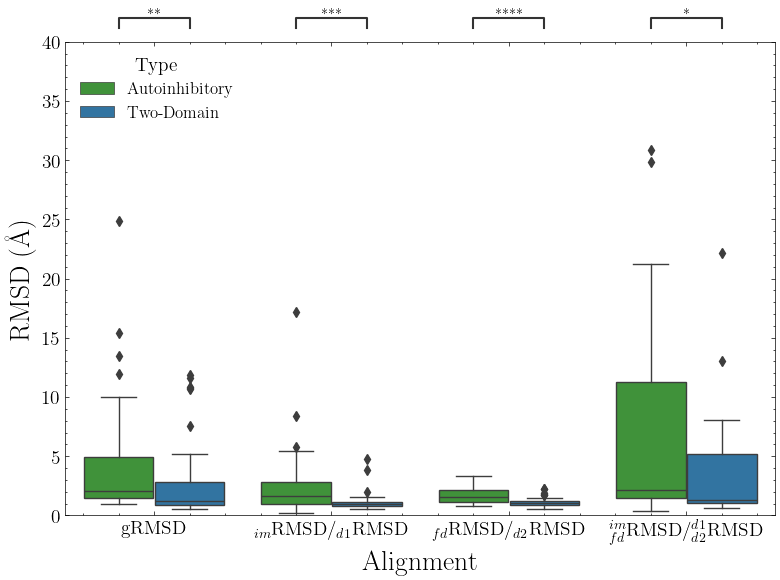

In [767]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=ming3plot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=ming3plot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/multi_conformation_only_ai_rmsd_distributions.png', dpi=500, bbox_inches='tight')

Just to be safe, I'll make a graph showing two-domain proteins with at least two structures

In [768]:
ming3plot2 = pd.concat([min_g3, min_md_g3]) # Minimum md if you want all 40 proteins
ming3plot2 = pd.melt(ming3plot2, id_vars=['UniProt', 'PDB', 'Type', 'diff'], var_name='Alignment', value_name='RMSD')
ming3plot2['RMSD'] = ming3plot2['RMSD'].astype(float)

/tmp/ipykernel_2592195/2352601736.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:6.854e-02 U_stat=1.290e+02
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.587e-01 U_stat=1.200e+02
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:6.854e-02 U_stat=1.290e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.123e-01 U_stat=1.110e+02


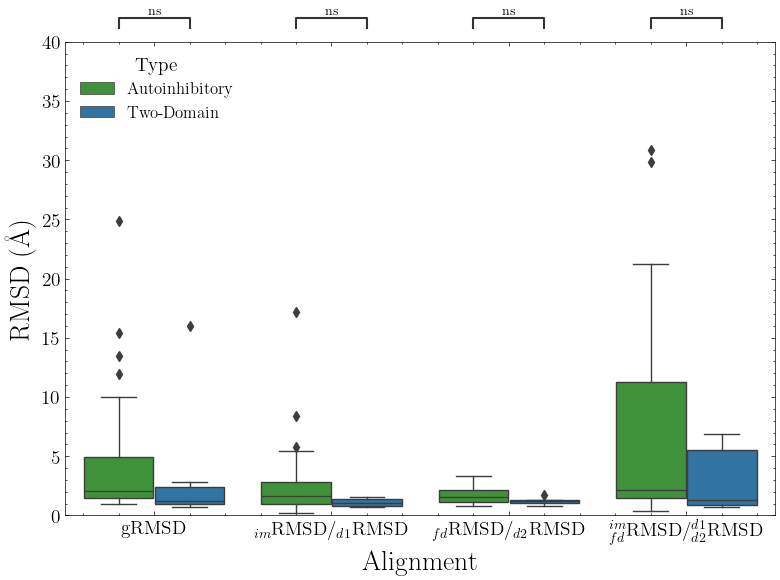

In [769]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=ming3plot2, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=ming3plot2, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/two_conf_both.png', dpi=500, bbox_inches='tight')

In [770]:
ming3plot.groupby('Type')['UniProt'].nunique()

Type
Autoinhibitory    29
Two-Domain        40
Name: UniProt, dtype: int64

Let's directly compare the minimums of single-conformation proteins against the minimums of the multi-conformation ones.

In [771]:
min_g3['Type'] = 'Multi-Conformation'
ming3uniprots = min_g3['UniProt'].unique().tolist()

min_ss = minimum_cl[~minimum_cl['UniProt'].isin(ming3uniprots)]
min_ss['Type'] = 'Single Conformation'

ai_only = pd.concat([min_g3, min_ss])
ai_only.head()

/tmp/ipykernel_2592195/239083974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_ss['Type'] = 'Single Conformation'


,UniProt,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,PDB,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,Type,diff
0,A0A0R4I961,1.135,6gtv,1.450,0.929,1.673,Multi-Conformation,3.163
1,O00571,1.984,7liu,2.074,1.660,2.105,Multi-Conformation,11.709
2,O08967,1.593,2r09,3.179,1.235,0.968,Multi-Conformation,52.441
3,P00579,45.352,4llg,13.459,2.344,1.750,Multi-Conformation,6.411
4,P07038,12.107,7nxf,4.914,5.410,1.812,Multi-Conformation,10.708


In [772]:
ai_only.columns = ['UniProt', imfd, 'PDB', 'gRMSD', im, fd, 'Type', 'diff']

In [773]:
aiPlot = pd.melt(ai_only, id_vars=['UniProt', 'PDB', 'Type', 'diff'], var_name='Alignment', value_name='RMSD')
aiPlot['RMSD'] = aiPlot['RMSD'].astype(float)

/tmp/ipykernel_2592195/2314025573.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_Multi-Conformation vs. $_{im}$RMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:7.716e-01 U_stat=1.384e+03
gRMSD_Multi-Conformation vs. gRMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:3.491e-01 U_stat=1.270e+03
$_{fd}$RMSD_Multi-Conformation vs. $_{fd}$RMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:2.084e-01 U_stat=1.214e+03
$_{fd}^{im}$RMSD_Multi-Conformation vs. $_{fd}^{im}$RMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:7.803e-01 U_stat=1.386e+03


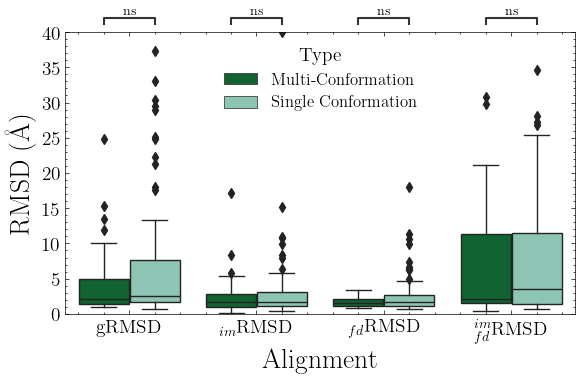

In [774]:
subcat_order = ['gRMSD', im, fd, imfd]

# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=aiPlot, x='Alignment', y='RMSD', ax=ax, palette=gns, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Single Conformation'), ('gRMSD', 'Multi-Conformation')],
         [(im, 'Single Conformation'), (im, 'Multi-Conformation')],
         [(fd, 'Single Conformation'), (fd, 'Multi-Conformation')],
         [(imfd, 'Single Conformation'), (imfd, 'Multi-Conformation')]]
annotator = Annotator(ax, pairs, data=aiPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_single_vs_multi_structures.png', dpi=500, bbox_inches='tight')

## Now we do the PAE

In [1030]:
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')

In [1031]:
# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)

df_single = df_single[['uniprot', 'mean_pae']].dropna()

In [1032]:
# Reformat the singles dataframe
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_auto = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_auto = df_auto[df_auto['uniprot'].isin(minimum_cl['UniProt'].unique())]
df_pae = df_auto.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 'mean_pae_2_2': 'FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 vs D2', 'mean_pae_2_2': 'D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
df_pae_melt['type'] = 'Autoinhibitory'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all['mean_pae'] = df_all['mean_pae'].astype('float')

/tmp/ipykernel_2592195/2885158586.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1 vs D2_Two-Domain vs. IM vs FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.232e-04 U_stat=2.406e+03
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.362e-05 U_stat=1.086e+04
D2_Two-Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.285e-14 U_stat=1.140e+03
D1_Two-Domain vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.475e-05 U_stat=2.386e+03
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.759e+03
Single Domain_Single Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferro

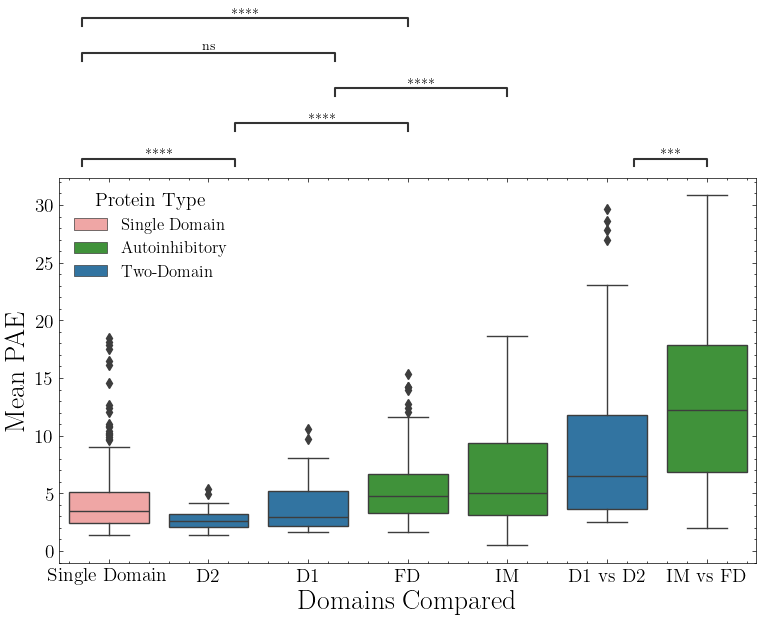

In [778]:
region_order = ['Single Domain', 'D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

f, ax = plt.subplots(figsize=(9, 5))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=20)
ax.set_ylabel('Mean PAE', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('IM vs FD', 'Autoinhibitory'), ('D1 vs D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/ai_sd_md_proteins_pae_annotated.png')

In [779]:
df_auto['uniprot'].nunique()

128

In [780]:
df_dis_melt = df_pae_melt[df_pae_melt['uniprot'].isin(dis_uniprots)]

df_dis_all = pd.concat([df_single_melt, df_dis_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_dis_all['mean_pae'] = df_dis_all['mean_pae'].astype('float')

In [781]:
df_dis_all.groupby('type')['uniprot'].nunique()

type
Autoinhibitory    105
Single Domain     258
Two-Domain         61
Name: uniprot, dtype: int64

/tmp/ipykernel_2592195/3503675567.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1 vs D2_Two-Domain vs. IM vs FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.508e-03 U_stat=2.109e+03
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.362e-05 U_stat=1.086e+04
D2_Two-Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.904e-14 U_stat=9.105e+02
D1_Two-Domain vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.091e-03 U_stat=2.084e+03
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.759e+03
Single Domain_Single Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferro

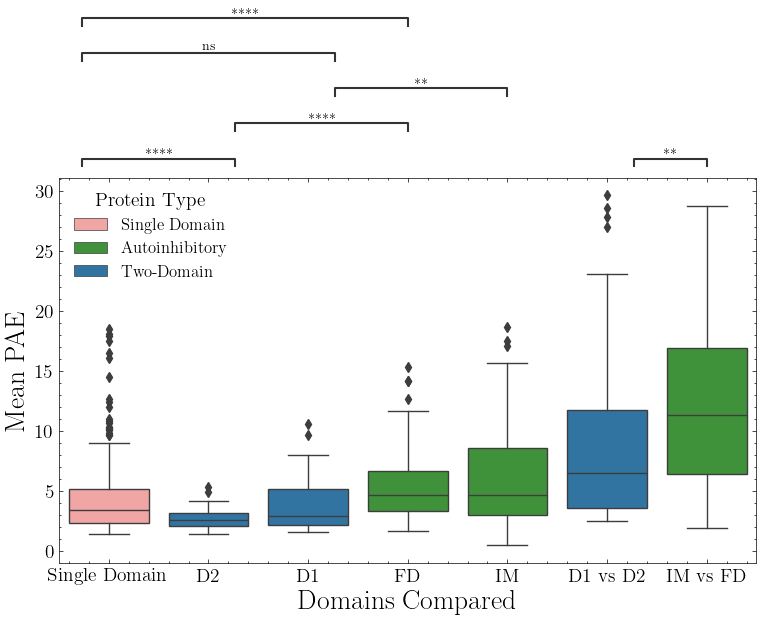

In [782]:
region_order = ['Single Domain', 'D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

f, ax = plt.subplots(figsize=(9, 5))
sns.boxplot(data=df_dis_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=20)
ax.set_ylabel('Mean PAE', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('IM vs FD', 'Autoinhibitory'), ('D1 vs D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_dis_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/structured_im_only_pae.png')

For only those proteins with ordered inhibitory modules.

In [783]:
# Add obligate column
obligate_uniprots = obli['uniprot'].unique().tolist()

df_obli_melt = df_multi_melt[df_multi_melt['uniprot'].isin(obligate_uniprots)]
df_obli_melt['type'] = 'Obligate'

df_all_plus_obli = pd.concat([df_all, df_obli_melt], ignore_index=True).drop_duplicates()

/tmp/ipykernel_2592195/3584162902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obli_melt['type'] = 'Obligate'


In [784]:
df_all_plus_obli = df_all_plus_obli[df_all_plus_obli['type'] != 'Two-Domain']
df_all_plus_obli['mean_pae'] = df_all_plus_obli['mean_pae'].astype('float')

In [785]:
df_all_plus_obli.groupby('type')['uniprot'].nunique()

type
Autoinhibitory    128
Obligate            7
Single Domain     258
Name: uniprot, dtype: int64

/tmp/ipykernel_2592195/2976766115.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1 vs D2_Obligate vs. IM vs FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.492e-03 U_stat=1.440e+02
Single Domain_Single Domain vs. D2_Obligate: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.053e+03
D2_Obligate vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.106e-01 U_stat=2.100e+02
D1_Obligate vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.301e-01 U_stat=2.660e+02
Single Domain_Single Domain vs. D1_Obligate: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.004e+03
Single Domain_Single Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correct

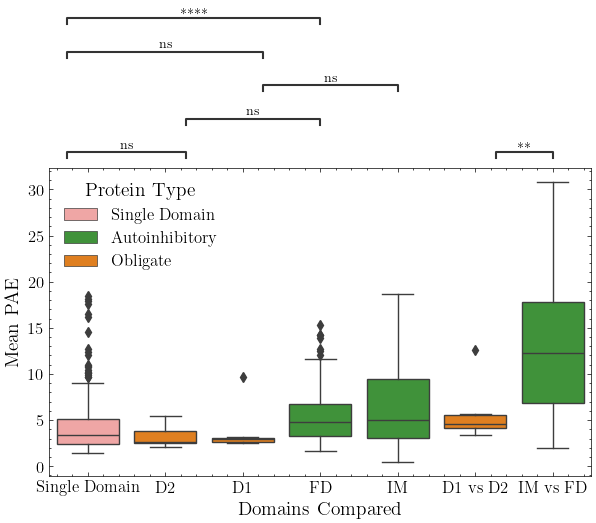

In [786]:
region_order = ['Single Domain', 'D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

f, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df_all_plus_obli, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2', 'Obligate')],
         [('Single Domain', 'Single Domain'), ('D1', 'Obligate')],
         [('FD', 'Autoinhibitory'), ('D2', 'Obligate')],
         [('IM', 'Autoinhibitory'), ('D1', 'Obligate')],
         [('IM vs FD', 'Autoinhibitory'), ('D1 vs D2', 'Obligate')]]
annotator = Annotator(ax, pairs, data=df_all_plus_obli, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/ai_sd_obli_proteins_pae_annotated.png')

## Full-Depth pLDDT

In [980]:
# Functions to rename columns

def rename_auto_columns(df):
    df = df.rename(columns={'complex_mean_plddt': 'Global AI', 'r1_mean_plddt': 'IM', 'r2_mean_plddt': 'FD'})

    return df

def rename_multi_columns(df):
    df = df.rename(columns={'complex_mean_plddt': 'Global TD', 'r1_mean_plddt': 'D1', 'r2_mean_plddt': 'D2'})

    return df

# Quick functions to melt dataframes
def pivot_af_df(df):

    df = df.melt(id_vars=['uniprot', 'region_1', 'region_2', 'af_filename'], var_name='Section', value_name='Mean pLDDT')
    df['Mean pLDDT'] = df['Mean pLDDT'].astype(float)

    return df

def pivot_cf_df(df):

    df = df.melt(id_vars=['uniprot', 'cluster', 'region_1', 'region_2'], var_name='Section', value_name='Mean pLDDT')
    df['Mean pLDDT'] = df['Mean pLDDT'].astype(float)

    return df

# Add signifier column
def add_auto_type(df):
    df['type'] = 'Autoinhibitory'

    return df

def add_multi_type(df):
    df['type'] = 'Two-Domain'

    return df

In [788]:
afAuto = pd.read_csv('./project_pipeline/data/ai_full-depth_pLDDT.tsv', sep='\t').astype('object')
afMulti = pd.read_csv('./project_pipeline/data/md_full-depth_pLDDT.tsv', sep='\t').astype('object')

In [789]:
afAuto = afAuto[['uniprot', 'region_1', 'region_2', 'af_filename', 'complex_mean_plddt', 'r1_mean_plddt', 'r2_mean_plddt']]
afMulti = afMulti[['uniprot', 'region_1', 'region_2', 'af_filename', 'complex_mean_plddt', 'r1_mean_plddt', 'r2_mean_plddt']]

In [790]:
afAuto['uniprot'].nunique()

128

In [791]:
afAuto = afAuto.drop_duplicates()
afAuto['r1_mean_plddt'].astype('float').describe()

count    128.000000
mean      81.248320
std       13.239812
min       37.542000
25%       74.893250
50%       84.223500
75%       91.533250
max       98.189000
Name: r1_mean_plddt, dtype: float64

In [792]:
# Rename columns
af_auto = rename_auto_columns(afAuto)
af_multi = rename_multi_columns(afMulti)

# Pivot dataframes
afAuto_p = pivot_af_df(af_auto)
afMulti_p = pivot_af_df(af_multi)

# Add type column
afAuto_p = add_auto_type(afAuto_p)
afMulti_p = add_multi_type(afMulti_p)

# Concatenate dataframes
af = pd.concat([afAuto_p, afMulti_p]).drop_duplicates()

In [793]:
af['uniprot'].nunique()

168

/tmp/ipykernel_2592195/3502442139.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_Autoinhibitory vs. Global TD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:5.945e-16 U_stat=3.870e+02
IM_Autoinhibitory vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.309e-13 U_stat=5.710e+02
FD_Autoinhibitory vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.574e-05 U_stat=1.400e+03


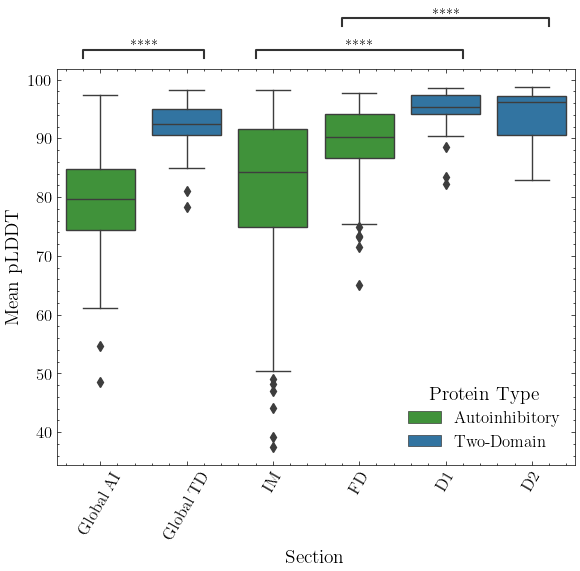

In [794]:
subcat_order = ['Global AI', 'Global TD', 'IM', 'FD', 'D1', 'D2']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=af, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order, dodge=False)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12')


# Annotate statistical significance
pairs = [[('Global AI', 'Autoinhibitory'), ('Global TD', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')]]

type_order = ['Autoinhibitory', 'Two-Domain']
annotator = Annotator(ax, pairs, data=af, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_md_full_depth_plddt.png', dpi=300, bbox_inches='tight')

pLDDT for only structured inhibitory modules now.

In [795]:
dis_Autop = afAuto_p[afAuto_p['uniprot'].isin(dis_uniprots)]

dis_af = pd.concat([dis_Autop, afMulti_p]).drop_duplicates()

/tmp/ipykernel_2592195/447695317.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_Autoinhibitory vs. Global TD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:6.129e-15 U_stat=3.360e+02
IM_Autoinhibitory vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.857e-12 U_stat=5.070e+02
FD_Autoinhibitory vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.771e-05 U_stat=1.152e+03


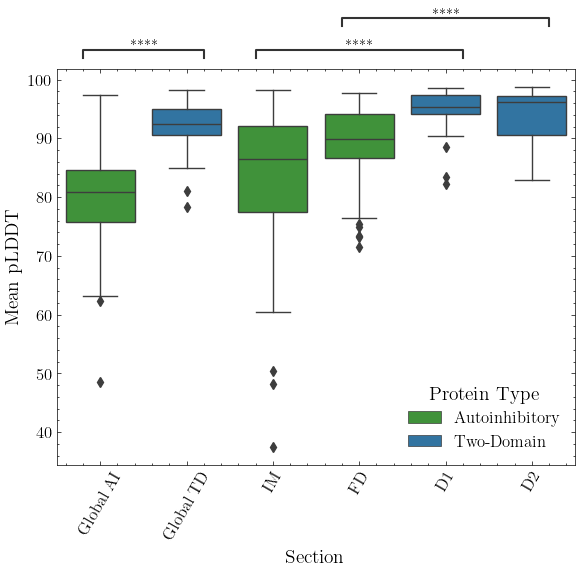

In [796]:
subcat_order = ['Global AI', 'Global TD', 'IM', 'FD', 'D1', 'D2']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=dis_af, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order, dodge=False)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12')


# Annotate statistical significance
pairs = [[('Global AI', 'Autoinhibitory'), ('Global TD', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')]]

type_order = ['Autoinhibitory', 'Two-Domain']
annotator = Annotator(ax, pairs, data=dis_af, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/structured_im_only_plddt.png', dpi=300, bbox_inches='tight')

## DockQ

In [797]:
ai1 = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv').astype('object')
md_dockq = pd.read_csv('./project_pipeline/data/md_pdb_full_depth_dockq.csv').astype('object')

ai1 = ai1.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
md_dockq = md_dockq.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})

In [798]:
ai1['UniProt'].nunique()

121

In [799]:
min_g3.head()

,UniProt,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,PDB,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,Type,diff
0,A0A0R4I961,1.135,6gtv,1.450,0.929,1.673,Multi-Conformation,3.163
1,O00571,1.984,7liu,2.074,1.660,2.105,Multi-Conformation,11.709
2,O08967,1.593,2r09,3.179,1.235,0.968,Multi-Conformation,52.441
3,P00579,45.352,4llg,13.459,2.344,1.750,Multi-Conformation,6.411
4,P07038,12.107,7nxf,4.914,5.410,1.812,Multi-Conformation,10.708


In [800]:
g3dockq = pd.merge(minimum_cl, ai1, on=['UniProt', 'PDB'], how='left').fillna(0).drop_duplicates(subset='UniProt')
g3dockq = g3dockq[g3dockq['capri'] != 0]
mddockq = pd.merge(md_dockq, minimum_md, on=['UniProt', 'PDB'], how='inner').fillna(0)

g3dockq['Type'] = 'Autoinhibitory'
mddockq['Type'] = 'Two-Domain'

In [801]:
set(minimum_cl['UniProt'].unique()) - set(g3dockq['UniProt'].unique())

{'P00579',
 'P04637',
 'P60240',
 'Q8R4B8',
 'Q8TCU6',
 'Q96P20',
 'Q96RD7',
 'Q9Y490'}

In [802]:
plot = pd.concat([g3dockq, mddockq], ignore_index=True)
plot.head()

,UniProt,gRMSD,PDB,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Type,fnat,fnat_correct,fnat_total,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri
0,A0A0R4I961,1.450,6gtv,0.929,1.673,1.135,Autoinhibitory,0.913,63.0,69.0,0.045,3.0,66.0,0.545,1.045,0.927,High
1,B5XAZ0,2.591,7bfl,0.656,2.760,0.807,Autoinhibitory,0.889,24.0,27.0,0.000,0.0,24.0,0.464,0.612,0.932,High
2,D2AJU0,3.539,6lol,0.945,2.829,7.860,Autoinhibitory,0.808,21.0,26.0,0.000,0.0,21.0,1.871,7.914,0.578,Medium
3,O00571,2.074,7liu,1.660,2.105,1.984,Autoinhibitory,0.833,80.0,96.0,0.158,15.0,95.0,1.096,1.531,0.818,High
4,O08722,0.922,3g5b,0.872,0.959,0.927,Autoinhibitory,0.934,142.0,152.0,0.066,10.0,152.0,0.692,0.551,0.918,High


In [803]:
plot['Type'].value_counts()

Autoinhibitory    120
Two-Domain         40
Name: Type, dtype: int64

/tmp/ipykernel_2592195/3965880577.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


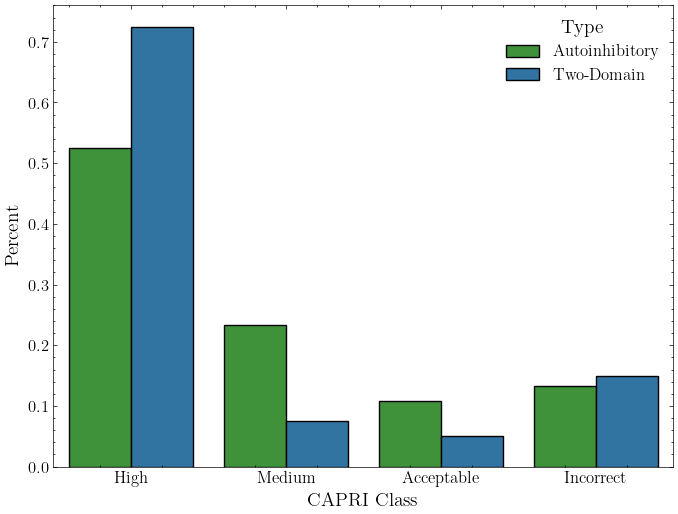

In [904]:
# We want percentages of CAPRI Classes
perc = plot.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc

# Make the CAPRI Class categorical
perc['capri'] = pd.Categorical(perc['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=perc, x='capri', y='Percent', hue='Type', palette=colors, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=14)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize='14', fontsize='12')

plt.savefig('./project_pipeline/data/figures/dockq_histograms.png', bbox_inches='tight', dpi=300)

In [805]:
plot.groupby('Type')['UniProt'].nunique()

Type
Autoinhibitory    120
Two-Domain         40
Name: UniProt, dtype: int64

## Looking at Proteins with Structures in the Training Set and Outside of the Training Set

In [806]:
# Get the dates data
ai_dates = pd.read_csv('./project_pipeline/data/ai_dates.tsv', sep='\t')
md_dates = pd.read_csv('./project_pipeline/data/md_dates.tsv', sep='\t')

# Get interpro data
interpro = pd.read_csv('./project_pipeline/data/interpro.tsv', sep='\t')

# Convert the dates to datetime objects
ai_dates['date'] = pd.to_datetime(ai_dates['date'])
md_dates['date'] = pd.to_datetime(md_dates['date'])

In [807]:
# The maximum release date for AlphaFold2 was April 30, 2018. Select only those structures released after this date
ai_after = ai_dates[ai_dates['date'] > datetime.datetime(2018, 4, 30)]
md_after = md_dates[md_dates['date'] > datetime.datetime(2018, 4, 30)]

ai_before = ai_dates[ai_dates['date'] <= datetime.datetime(2018, 4, 30)]
md_before = md_dates[md_dates['date'] <= datetime.datetime(2018, 4, 30)]

In [808]:
# Let's find the proteins with structures both before and after the release date
ai_before_uniprots = ai_before['uniprot'].unique().tolist()
ai_after_uniprots = ai_after['uniprot'].unique().tolist()

md_before_uniprots = md_before['uniprot'].unique().tolist()
md_after_uniprots = md_after['uniprot'].unique().tolist()

ai_only_after = list(set(ai_after_uniprots).difference(set(ai_before_uniprots)))
md_only_after = list(set(md_after_uniprots).difference(set(md_before_uniprots)))

print(len(ai_only_after), len(md_only_after))

30 8


In [809]:
multi_conf_ai_after = min_g3[min_g3['UniProt'].isin(ai_only_after)]
best_md_after = minimum_md[minimum_md['UniProt'].isin(md_only_after)].reset_index(drop=True)
best_ai_after = minimum_cl[minimum_cl['UniProt'].isin(ai_only_after)]

In [810]:
# Add gene names
gene_names = pd.read_csv('./source_protein_lists/Autoinhibited proteins (more added by Brooks).csv')
gene_names.head()

/tmp/ipykernel_2592195/1606980015.py:2: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_names = pd.read_csv('./source_protein_lists/Autoinhibited proteins (more added by Brooks).csv')


,Protein name,Gene names,Protein length,Uniprot ID,Species,Autoinhibitory regions,References,Description (Refer to H and I),Evidence,Structure?,...,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,ALK tyrosine kinase receptor (EC 2.7.10.1) (An...,ALK,1620.0,Q9UM73,Homo sapiens (Human),1096-1103(β1'-sheet and β2'-sheet);1271-1277(α...,20695522,ALK is a receptor tyrosine kinase involved in ...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BH3-interacting domain death agonist (p22 BID)...,BID,195.0,P55957,Homo sapiens (Human),14-41(N-terminal autoinhibitory region),10089877,BID is a proapoptotic member of the BCL2 famil...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tyrosine-protein kinase Blk (EC 2.7.10.2) (B l...,BLK,505.0,P51451,Homo sapiens (Human),58-118(SH3 domain);221-240(SH2-CD linker);376-...,15489910,Tyrosine-protein kinase Blk plays an important...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Calcium/calmodulin-dependent protein kinase ty...,CAMK2B CAM2 CAMK2 CAMKB,666.0,Q13554,Homo sapiens (Human),283-292(Autoinhibitory domain),20668654,CAMK2B is a Calcium/Calmodulin (CaM)-dependent...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Calcium/calmodulin-dependent protein kinase ty...,CAMK2D CAMKD,499.0,Q13557,Homo sapiens (Human),283-292(Autoinhibitory domain),20668654,CAMK2D is a Calcium/Calmodulin (CaM)-dependent...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [811]:
interpro = interpro.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})

In [812]:
names_only = gene_names[['Uniprot ID', 'Gene names', 'Protein name']]
best_ai_after_gn = pd.merge(best_ai_after, names_only, left_on='UniProt', right_on='Uniprot ID', how='left')
best_ai_after_gn.columns

Index(['UniProt', 'gRMSD', 'PDB', '$_{im}$RMSD/$_{d1}$RMSD',
       '$_{fd}$RMSD/$_{d2}$RMSD', '$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD', 'Type',
       'Uniprot ID', 'Gene names', 'Protein name'],
      dtype='object')

In [813]:
best_ai_after_gn = pd.merge(best_ai_after_gn, interpro, on=['UniProt', 'PDB'], how='left')
best_ai_after_gn.columns
best_ai_after_gn = best_ai_after_gn.drop(columns=['notes', 'date', 'region_1', 'region_2', 'percent_region_1', 'percent_region_2',
                                                '2_aligned', '2_comp', 'complex_rmsd', 'state', 'conformation', 'organism', 'Uniprot ID', 'Type'])

In [814]:
best_ai_after_gn

,UniProt,gRMSD,PDB,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Gene names,Protein name,domain,homologous_superfamily,family,active_site,conserved_site,repeat,binding_site,ptm
0,B5XAZ0,2.591,7bfl,0.656,2.760,0.807,ANG1,Angiogenin-1,Ribonuclease A-domain,Ribonuclease A-like domain superfamily,Pancreatic ribonuclease,"Ribonuclease A, active site",NaN,NaN,NaN,NaN
1,D2AJU0,3.539,6lol,0.945,2.829,7.860,ipaH9.8 SFxv_5076,E3 ubiquitin-protein ligase ipaH9.8 (EC 2.3.2....,"Novel E3 ligase domain, LRR-containing bacteri...",Leucine-rich repeat domain superfamily,NaN,NaN,NaN,NaN,NaN,NaN
2,O95376,1.926,7od1,1.319,1.145,3.092,ARIH2 ARI2 TRIAD1 HT005,E3 ubiquitin-protein ligase ARIH2 (ARI-2) (Pro...,"Zinc finger, RING-type, IBR domain, TRIAD supr...","Zinc finger, RING/FYVE/PHD-type",E3 ubiquitin ligase RBR family,NaN,"Zinc finger, RING-type, conserved site",NaN,NaN,NaN
3,P09769,1.930,7uy0,1.356,1.323,2.425,FGR SRC2,Tyrosine-protein kinase Fgr (EC 2.7.10.2) (Gar...,"Protein kinase domain, SH2 domain, Serine-thre...","Protein kinase-like domain superfamily, SH3-li...",NaN,"Tyrosine-protein kinase, active site",NaN,NaN,"Protein kinase, ATP binding site",NaN
4,Q14674,5.868,7nj0,3.423,4.668,5.274,ESPl1,Separin,SEPARIN core domain,NaN,"Peptidase C50, separase",NaN,NaN,NaN,NaN,NaN
5,Q6SZW1,1.709,7cm6,0.962,1.016,2.948,SARM1,NAD(+) hydrolase SARM1,Toll/interleukin-1 receptor homology (TIR) dom...,"Armadillo-like helical, Sterile alpha motif/po...",Sterile alpha and TIR motif-containing protein 1,NaN,NaN,NaN,NaN,NaN
6,Q86WJ1,24.842,7epu,3.875,6.410,25.112,CHD1L,Chromodomain-helicase-DNA-binding protein 1-like,"SNF2, N-terminal, Helicase, C-terminal, Macro ...",P-loop containing nucleoside triphosphate hydr...,Chromodomain-helicase-DNA-binding protein 1-like,NaN,"DNA/RNA helicase, ATP-dependent, DEAH-box type...",NaN,NaN,NaN
7,Q8R4B8,13.366,7vtq,1.285,6.638,47.240,Nlrp3 Cias1 Mmig1 Nalp3 Pypaf1,"NACHT, LRR and PYD domains-containing protein ...","DAPIN domain, NACHT nucleoside triphosphatase,...","Death-like domain superfamily, P-loop containi...",NaN,NaN,NaN,Leucine-rich repeat,NaN,NaN
8,Q96RD7,11.566,6m02,5.523,11.360,27.251,PANX1 MRS1 UNQ2529/PRO6028,Pannexin-1,NaN,NaN,"Innexin, Pannexin",NaN,NaN,NaN,NaN,NaN
9,Q9NPP4,21.290,8fw2,5.774,2.340,42.119,NLRC4 CARD12 CLAN CLAN1 IPAF UNQ6189/PRO20215,NLR family CARD domain-containing protein 4 (C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [815]:
md_gene_names = {'Protein name': ['Putative ATP-dependent b-aminoacyl-ACP synthetase', 'Cfl',
                                  'Fructose-1,6-bisphosphatase 1', '2,3-dihydroxybenzoate-AMP ligase',
                                  '2-methylcitrate dehydratase'],
                 'Gene names': ['hitB', 'Cfl',
                                'FBP1', np.nan,
                                'prpD']}

md_genes_df = pd.DataFrame(md_gene_names)
best_md_after_gn = pd.merge(best_md_after, md_genes_df, how='left', left_index=True, right_index=True)

In [816]:
best_md_after_gn[['UniProt', 'PDB', imfdd1d2, 'gRMSD', 'Gene names', 'Protein name']]

,UniProt,PDB,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,gRMSD,Gene names,Protein name
0,A0A0F7R6G7,6m01,6.903,2.806,hitB,Putative ATP-dependent b-aminoacyl-ACP synthetase
1,M4GWN4,7a9i,13.047,5.219,Cfl,Cfl
2,Q2TU34,5zwk,3.829,2.921,FBP1,"Fructose-1,6-bisphosphatase 1"
3,Q47NR5,6e97,60.475,11.86,NaN,"2,3-dihydroxybenzoate-AMP ligase"
4,Q9I5E6,6s62,8.086,3.348,prpD,2-methylcitrate dehydratase


In [817]:
# Turn it into plotting form
afterPlot = pd.concat([best_md_after, best_ai_after])

# Melt the data
afterPlot = pd.melt(afterPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
afterPlot['RMSD'] = afterPlot['RMSD'].astype(float)

/tmp/ipykernel_2592195/803084829.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


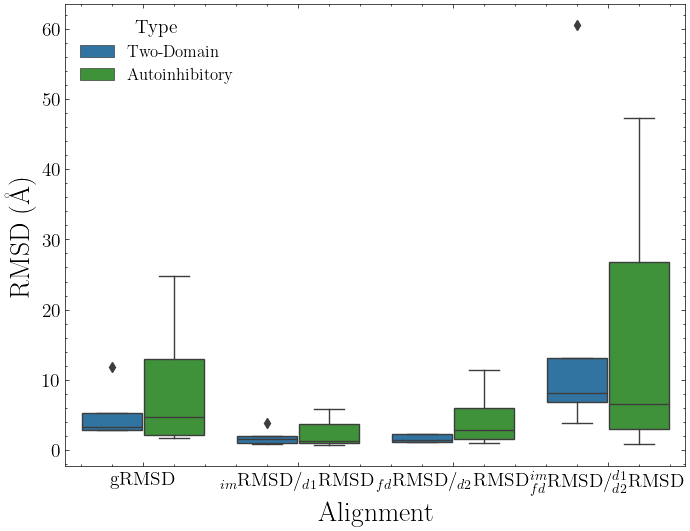

In [818]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=afterPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

plt.savefig('./project_pipeline/data/figures/not_in_training_set.png', bbox_inches='tight', dpi=500)

## Comparing minimum of PDB-Cluster vs PDB-Full Depth

In [819]:
clust = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t').astype('object')

In [820]:
# Rename the columns
clust = clust.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster', 'complex_rmsd': 'gRMSD',
                              '1_aligned': im, '2_aligned': fd, '2_comp': imfd})
min_g3 = min_g3.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

clust['Type'] = 'Cluster'
min_g3['Type'] = 'Full Depth'

In [821]:
# Get the minimum for the clusters per protein
min_clust = clust.groupby('UniProt')['gRMSD'].min().reset_index()
min_clust = pd.merge(min_clust, clust, on=['UniProt', 'gRMSD'], how='inner').drop_duplicates(subset='UniProt')

min_clust.shape

(38, 25)

In [910]:
# What about the minimums for every cluster?
min_clust_all = clust.groupby(['UniProt', 'Cluster'])['gRMSD'].min().reset_index()
min_clust_uniform = min_clust_all[min_clust_all['Cluster'].str.contains('U')]
min_clust_uniform.shape

(740, 3)

In [822]:
# Find common uniprots between minimum_cl and min_clust
clust_uniprots = min_clust['UniProt'].unique().tolist()
class_uniprots = min_g3['UniProt'].unique().tolist()
all_class_uniprots = minimum_cl['UniProt'].unique().tolist()

common_uniprots = list(set(clust_uniprots).intersection(all_class_uniprots))

to_plot_clust = min_clust[min_clust['UniProt'].isin(common_uniprots)]
to_plot_class = minimum_cl[minimum_cl['UniProt'].isin(common_uniprots)]

to_plot_clust['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
to_plot_class['Type'] = 'Full Depth'

to_plot_class = to_plot_class.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

to_plot = pd.concat([to_plot_clust, to_plot_class])

to_plot = to_plot[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

/tmp/ipykernel_2592195/973839434.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_class['Type'] = 'Full Depth'


In [823]:
to_plot_class['PDB'].nunique()

38

In [824]:
to_plot_clust[to_plot_clust['gRMSD'] <= 3].shape

(15, 25)

In [825]:
# Melt the data for plotting
to_plot_melt = pd.melt(to_plot, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot_melt['RMSD'] = to_plot_melt['RMSD'].astype(float)
to_plot_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,B5XAZ0,7bfl,AI Cluster (w/ Uniform Clstrs.),001,gRMSD,1.954
1,D2AJU0,6lol,AI Cluster (w/ Uniform Clstrs.),U10-009,gRMSD,5.493
2,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,gRMSD,8.897
3,O60741,5u6o,AI Cluster (w/ Uniform Clstrs.),U10-000,gRMSD,19.891
4,O76074,3mf0,AI Cluster (w/ Uniform Clstrs.),U100-001,gRMSD,7.514


In [826]:
to_plot_melt['Type'].value_counts()

AI Cluster (w/ Uniform Clstrs.)    152
Full Depth                         152
Name: Type, dtype: int64

/tmp/ipykernel_2592195/2461912864.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.226e-02 U_stat=9.180e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:9.138e-02 U_stat=8.850e+02
$_{fd}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.247e-02 U_stat=9.630e+02
$_{fd}^{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.532e-01 U_stat=8.600e+02


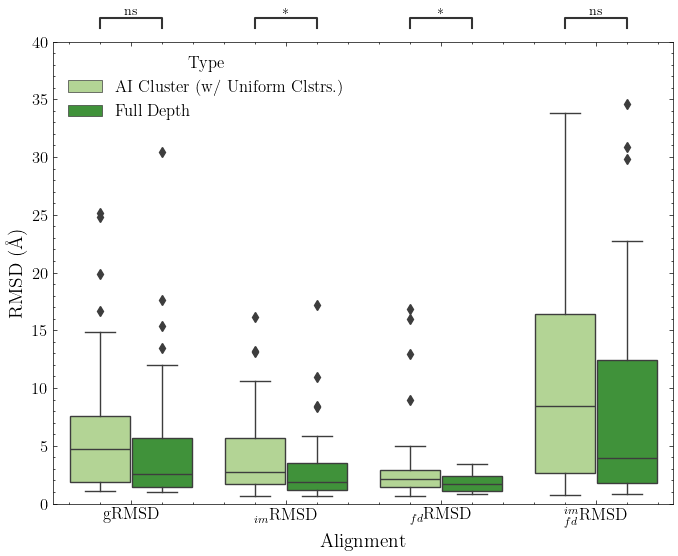

In [827]:
# Change the palette for just this plot
clust_colors = {'Full Depth': pal[3], 'AI Cluster (w/ Uniform Clstrs.)': pal[2]}

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=to_plot_melt, x='Alignment', y='RMSD', ax=ax, palette=clust_colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Full Depth'), ('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)')],
         [(im, 'Full Depth'), (im, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(fd, 'Full Depth'), (fd, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(imfd, 'Full Depth'), (imfd, 'AI Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', im, fd, imfd]
annotator = Annotator(ax, pairs, data=to_plot_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/ai_all_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

Look at only non-uniform clusters.

In [828]:
no_u = clust[~clust['Cluster'].str.contains('U')].reset_index(drop=True)

no_u['Type'] = 'AI Cluster (w/o Uniform Clstrs.)'

min_nou = no_u.groupby('UniProt')[imfd].min()
min_nou = pd.merge(min_nou, no_u, on=['UniProt', imfd], how='inner').drop_duplicates(subset='UniProt')

In [829]:
no_uniprots = min_nou['UniProt'].unique().tolist()

common_uniprots2 = list(set(no_uniprots).intersection(all_class_uniprots))

to_plot_nou = min_nou[min_nou['UniProt'].isin(common_uniprots2)]

to_plot2 = pd.concat([to_plot_nou, to_plot_class])

to_plot2 = to_plot2[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

In [899]:
to_plot_nou.shape

(34, 25)

In [830]:
to_plot_class[['gRMSD', im, fd, imfd]].astype(float).describe()

,gRMSD,$_{im}$RMSD,$_{fd}$RMSD,$_{fd}^{im}$RMSD
count,38.000000,38.000000,38.000000,38.000000
mean,5.033947,3.117947,1.753079,10.559132
std,6.029770,3.298293,0.705497,14.764120
min,1.031000,0.656000,0.798000,0.807000
25%,1.445500,1.192750,1.106250,1.762750
50%,2.540000,1.889000,1.710500,3.926500
75%,5.687250,3.491250,2.353750,12.398750
max,30.431000,17.161000,3.446000,70.729000


In [831]:
# Melt the data for plotting
to_plot_melt2 = pd.melt(to_plot2, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot_melt2['RMSD'] = to_plot_melt2['RMSD'].astype(float)
to_plot_melt2.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,B5XAZ0,7bfk,AI Cluster (w/o Uniform Clstrs.),013,gRMSD,3.197
1,D2AJU0,6lol,AI Cluster (w/o Uniform Clstrs.),001,gRMSD,5.594
2,O08967,2r0d,AI Cluster (w/o Uniform Clstrs.),005,gRMSD,15.676
3,O60741,6uqg,AI Cluster (w/o Uniform Clstrs.),000,gRMSD,23.507
4,O76074,3mf0,AI Cluster (w/o Uniform Clstrs.),005,gRMSD,8.746


In [832]:
to_plot_melt2['Type'].value_counts()

Full Depth                          152
AI Cluster (w/o Uniform Clstrs.)    136
Name: Type, dtype: int64

/tmp/ipykernel_2592195/896786558.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_AI Cluster (w/o Uniform Clstrs.) vs. $_{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:6.903e-03 U_stat=8.860e+02
gRMSD_AI Cluster (w/o Uniform Clstrs.) vs. gRMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.473e-04 U_stat=9.830e+02
$_{fd}$RMSD_AI Cluster (w/o Uniform Clstrs.) vs. $_{fd}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:3.528e-07 U_stat=1.098e+03
$_{fd}^{im}$RMSD_AI Cluster (w/o Uniform Clstrs.) vs. $_{fd}^{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.063e-02 U_stat=8.280e+02


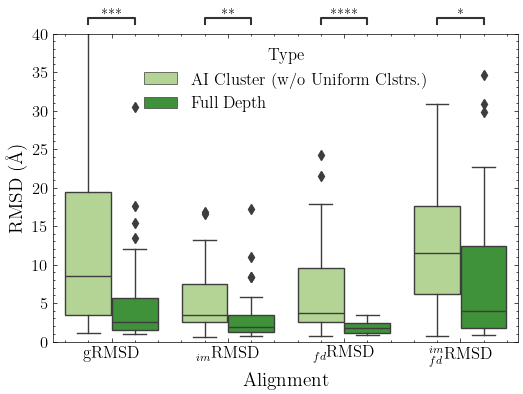

In [833]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=to_plot_melt2, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Full Depth'), ('gRMSD', 'AI Cluster (w/o Uniform Clstrs.)')],
         [(im, 'Full Depth'), (im, 'AI Cluster (w/o Uniform Clstrs.)')],
         [(fd, 'Full Depth'), (fd, 'AI Cluster (w/o Uniform Clstrs.)')],
         [(imfd, 'Full Depth'), (imfd, 'AI Cluster (w/o Uniform Clstrs.)')]]
subcat_order = ['gRMSD', im, fd, imfd]
annotator = Annotator(ax, pairs, data=to_plot_melt2, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/ai_fd_vs_no_u_clust.png', dpi=500, bbox_inches='tight')

Now look at only structures with at least two conformations.

In [834]:
common_uniprots_ai = list(set(clust_uniprots).intersection(class_uniprots))

to_plot_clust2 = min_clust[min_clust['UniProt'].isin(common_uniprots_ai)]
to_plot_class2 = minimum_cl[minimum_cl['UniProt'].isin(common_uniprots_ai)]

to_plot_clust2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
to_plot_class2['Type'] = 'Full Depth'

to_plot_class2 = to_plot_class2.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

to_plot_two_confs = pd.concat([to_plot_clust2, to_plot_class2])

to_plot_two_confs = to_plot_two_confs[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

/tmp/ipykernel_2592195/2963792978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_clust2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
/tmp/ipykernel_2592195/2963792978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_class2['Type'] = 'Full Depth'


In [835]:
to_plot_class2['UniProt'].nunique()

16

In [836]:
# Melt the data for plotting
to_plot_2confs_melt = pd.melt(to_plot_two_confs, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot_2confs_melt['RMSD'] = to_plot_2confs_melt['RMSD'].astype(float)
to_plot_2confs_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,gRMSD,8.897
1,P00579,4lk1,AI Cluster (w/ Uniform Clstrs.),U100-000,gRMSD,16.681
2,P07038,7nxf,AI Cluster (w/ Uniform Clstrs.),U100-002,gRMSD,5.015
3,P12931,7yqe,AI Cluster (w/ Uniform Clstrs.),U10-007,gRMSD,1.402
4,P21333,2j3s,AI Cluster (w/ Uniform Clstrs.),U100-008,gRMSD,9.890


In [837]:
to_plot_2confs_melt['Type'].value_counts()

AI Cluster (w/ Uniform Clstrs.)    64
Full Depth                         64
Name: Type, dtype: int64

/tmp/ipykernel_2592195/676335794.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.503e-01 U_stat=1.590e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:3.758e-01 U_stat=1.520e+02
$_{fd}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:5.226e-02 U_stat=1.800e+02
$_{fd}^{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:6.647e-01 U_stat=1.400e+02


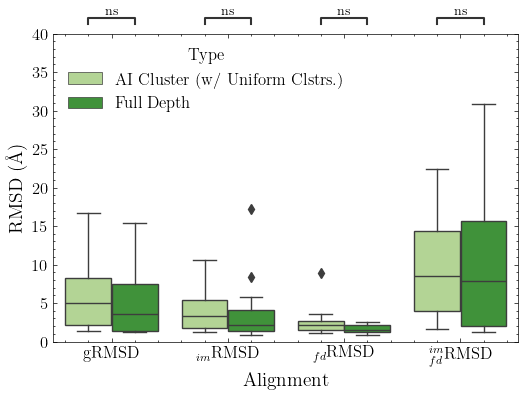

In [838]:
# Change the palette for just this plot
clust_colors = {'Full Depth': pal[3], 'AI Cluster (w/ Uniform Clstrs.)': pal[2]}

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=to_plot_2confs_melt, x='Alignment', y='RMSD', ax=ax, palette=clust_colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Full Depth'), ('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)')],
         [(im, 'Full Depth'), (im, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(fd, 'Full Depth'), (fd, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(imfd, 'Full Depth'), (imfd, 'AI Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', im, fd, imfd]
annotator = Annotator(ax, pairs, data=to_plot_2confs_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/ai_2confs_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

### Looking at the multi-domain clusters

In [839]:
mdclust = pd.read_csv('./project_pipeline/data/md_pdb_cluster_compared.tsv', sep='\t').astype('object')

In [840]:
# Rename the columns
mdclust = mdclust.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster', 'complex_rmsd': 'gRMSD',
                              '1_aligned': d1, '2_aligned': d2, '2_comp': d1d2})
minimum_md2 = minimum_md.rename(columns={imfdd1d2: d1d2, imd1: d1, fdd2: d2})

mdclust['Type'] = 'Cluster'
minimum_md2['Type'] = 'TD Full Depth'

In [841]:
# Get the minimum for the clusters
min_md_clust = mdclust.groupby('UniProt')[d1d2].min().reset_index()
min_md_clust = pd.merge(min_md_clust, mdclust, on=['UniProt', d1d2], how='inner').drop_duplicates(subset='UniProt')

min_md_clust['UniProt'].nunique()

27

In [842]:
# Find common uniprots between minimum_cl and min_clust
mdclust_uniprots = min_md_clust['UniProt'].unique().tolist()
mdclass_uniprots = minimum_md2['UniProt'].unique().tolist()

mdcommon_uniprots = list(set(mdclust_uniprots).intersection(mdclass_uniprots))

mdto_plot_clust = min_md_clust[min_md_clust['UniProt'].isin(mdcommon_uniprots)]
mdto_plot_class = minimum_md2[minimum_md2['UniProt'].isin(mdcommon_uniprots)]

mdto_plot_clust['Type'] = 'TD Cluster (w/ Uniform Clstrs.)'

mdto_plot = pd.concat([mdto_plot_clust, mdto_plot_class])

mdto_plot = mdto_plot[['UniProt', 'PDB', 'Cluster', 'gRMSD', d1, d2, d1d2, 'Type']]

In [843]:
mdto_plot_class[mdto_plot_class['gRMSD'] <= 3].shape

(23, 7)

In [844]:
# Melt the data for plotting
mdto_plot_melt = pd.melt(mdto_plot, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
mdto_plot_melt['RMSD'] = mdto_plot_melt['RMSD'].astype(float)
mdto_plot_melt[mdto_plot_melt['Type'] == 'TD Full Depth']

,UniProt,PDB,Type,Cluster,Alignment,RMSD
27,A0A0A0V031,5ups,TD Full Depth,NaN,gRMSD,0.914
28,A0A0F7R6G7,6m01,TD Full Depth,NaN,gRMSD,2.806
29,A0A0H2WY27,5ty7,TD Full Depth,NaN,gRMSD,0.770
30,A0A140DJY3,5wm5,TD Full Depth,NaN,gRMSD,1.296
31,A0A3B6UEQ0,7vxq,TD Full Depth,NaN,gRMSD,0.818
...,...,...,...,...,...,...
211,Q72AS4,3zea,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,0.617
212,Q7KLV9,3txn,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,1.758
213,Q8GN86,3cw9,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,58.555
214,Q941M3,3a9v,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,56.136


In [845]:
mdto_plot_melt['Type'].value_counts()

TD Cluster (w/ Uniform Clstrs.)    108
TD Full Depth                      108
Name: Type, dtype: int64

/tmp/ipykernel_2592195/1030531498.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.) vs. $_{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.802e-04 U_stat=5.750e+02
gRMSD_TD Cluster (w/ Uniform Clstrs.) vs. gRMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:8.950e-04 U_stat=5.570e+02
$_{d2}$RMSD_TD Cluster (w/ Uniform Clstrs.) vs. $_{d2}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.793e-05 U_stat=6.000e+02
$_{d2}^{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.) vs. $_{d2}^{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:3.710e-02 U_stat=4.855e+02


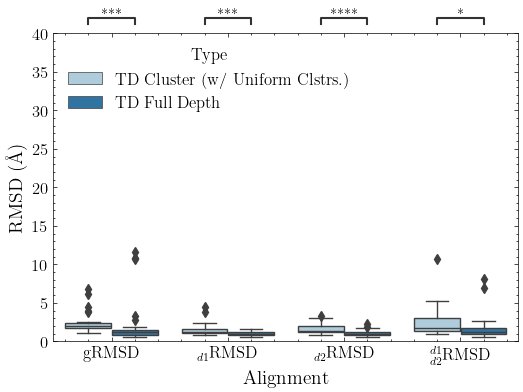

In [846]:
md_clust_colors = {'TD Full Depth': pal[1], 'TD Cluster (w/ Uniform Clstrs.)': pal[0]}

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=mdto_plot_melt, x='Alignment', y='RMSD', ax=ax, palette=md_clust_colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'TD Full Depth'), ('gRMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(d1, 'TD Full Depth'), (d1, 'TD Cluster (w/ Uniform Clstrs.)')],
         [(d2, 'TD Full Depth'), (d2, 'TD Cluster (w/ Uniform Clstrs.)')],
         [(d1d2, 'TD Full Depth'), (d1d2, 'TD Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', d1, d2, d1d2]
annotator = Annotator(ax, pairs, data=mdto_plot_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/md_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

Looking only at the obligate proteins.

In [847]:
mdto_plot_obli_clust = min_md_clust[min_md_clust['UniProt'].isin(obli_uniprots)]
mdto_plot_obli_class = minimum_md2[minimum_md2['UniProt'].isin(obli_uniprots)]

mdto_plot_obli_clust['Type'] = 'Obligate Cluster (w/ Uniform Clstrs.)'
mdto_plot_obli_class['Type'] = 'Obligate Full Depth'

mdto_plot_obli = pd.concat([mdto_plot_obli_clust, mdto_plot_obli_class])

mdto_plot_obli = mdto_plot_obli[['UniProt', 'PDB', 'Cluster', 'gRMSD', d1, d2, d1d2, 'Type']]

/tmp/ipykernel_2592195/979203124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdto_plot_obli_clust['Type'] = 'Obligate Cluster (w/ Uniform Clstrs.)'
/tmp/ipykernel_2592195/979203124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdto_plot_obli_class['Type'] = 'Obligate Full Depth'


In [848]:
mdto_plot_obli_melt = pd.melt(mdto_plot_obli, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
mdto_plot_obli_melt['RMSD'] = mdto_plot_obli_melt['RMSD'].astype(float)
mdto_plot_obli_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,O60729,1ohc,Obligate Cluster (w/ Uniform Clstrs.),U100-007,gRMSD,1.791
1,O69275,2j3z,Obligate Cluster (w/ Uniform Clstrs.),U10-001,gRMSD,2.552
2,P04807,1ig8,Obligate Cluster (w/ Uniform Clstrs.),004,gRMSD,1.774
3,P04958,4j1l,Obligate Cluster (w/ Uniform Clstrs.),U10-008,gRMSD,2.071
4,P0AG30,1a62,Obligate Cluster (w/ Uniform Clstrs.),018,gRMSD,3.854


/tmp/ipykernel_2592195/3384611536.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{d1}$RMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. $_{d1}$RMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.622e-02 U_stat=4.200e+01
gRMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. gRMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:6.993e-03 U_stat=4.500e+01
$_{d2}$RMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. $_{d2}$RMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.079e-03 U_stat=4.600e+01
$_{d2}^{d1}$RMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. $_{d2}^{d1}$RMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:9.732e-02 U_stat=3.800e+01


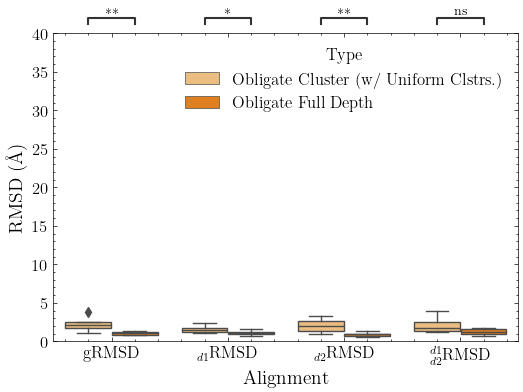

In [849]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=mdto_plot_obli_melt, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Obligate Full Depth'), ('gRMSD', 'Obligate Cluster (w/ Uniform Clstrs.)')],
         [(d1, 'Obligate Full Depth'), (d1, 'Obligate Cluster (w/ Uniform Clstrs.)')],
         [(d2, 'Obligate Full Depth'), (d2, 'Obligate Cluster (w/ Uniform Clstrs.)')],
         [(d1d2, 'Obligate Full Depth'), (d1d2, 'Obligate Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', d1, d2, d1d2]
annotator = Annotator(ax, pairs, data=mdto_plot_obli_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/obli_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

In [850]:
mdno_u = mdclust[~mdclust['Cluster'].str.contains('U')].reset_index(drop=True)

mdno_u['Type'] = 'TD Cluster (w/o Uniform Clstrs.)'

mdmin_nou = mdno_u.groupby('UniProt')[d1d2].min()
mdmin_nou = pd.merge(mdmin_nou, mdno_u, on=['UniProt', d1d2], how='inner').drop_duplicates(subset='UniProt')

In [851]:
mdno_uniprots = mdmin_nou['UniProt'].unique().tolist()

mdcommon_uniprots2 = list(set(mdno_uniprots).intersection(mdclass_uniprots))

mdto_plot_nou = mdmin_nou[mdmin_nou['UniProt'].isin(mdcommon_uniprots2)]

mdto_plot2 = pd.concat([mdto_plot_nou, mdto_plot_class])

mdto_plot2 = mdto_plot2[['UniProt', 'PDB', 'Cluster', 'gRMSD', d1, d2, d1d2, 'Type']]

In [852]:
mdto_plot_nou[['gRMSD', d1, d2, d1d2]].astype(float).describe()

,gRMSD,$_{d1}$RMSD,$_{d2}$RMSD,$_{d2}^{d1}$RMSD
count,23.000000,23.000000,23.000000,23.000000
mean,12.077043,7.270217,5.803478,14.731261
std,13.637417,8.032977,8.918208,23.217087
min,1.400000,1.057000,0.963000,1.151000
25%,2.891500,1.451000,1.758500,2.158000
50%,4.998000,2.575000,2.970000,5.889000
75%,16.432000,11.378500,4.122500,19.893000
max,50.568000,26.040000,38.742000,107.120000


In [853]:
# Melt the data for plotting
mdto_plot_melt2 = pd.melt(mdto_plot2, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
mdto_plot_melt2['RMSD'] = mdto_plot_melt2['RMSD'].astype(float)
mdto_plot_melt2['Alignment'].unique()

array(['gRMSD', '$_{d1}$RMSD', '$_{d2}$RMSD', '$_{d2}^{d1}$RMSD'],
      dtype=object)

/tmp/ipykernel_2592195/2549616542.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{d1}$RMSD_TD Cluster (w/o Uniform Clstrs.) vs. $_{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.246e-07 U_stat=5.770e+02
gRMSD_TD Cluster (w/o Uniform Clstrs.) vs. gRMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.030e-06 U_stat=5.620e+02
$_{d2}$RMSD_TD Cluster (w/o Uniform Clstrs.) vs. $_{d2}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.364e-07 U_stat=5.765e+02
$_{d2}^{d1}$RMSD_TD Cluster (w/o Uniform Clstrs.) vs. $_{d2}^{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.940e-04 U_stat=4.970e+02


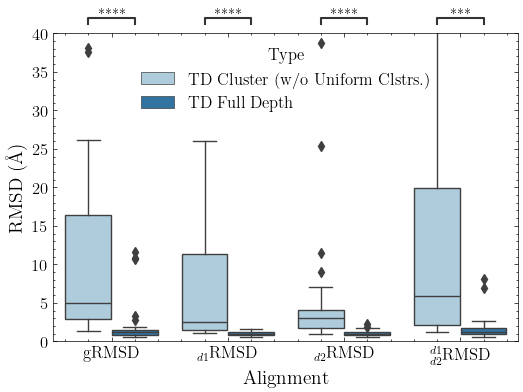

In [854]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=mdto_plot_melt2, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'TD Full Depth'), ('gRMSD', 'TD Cluster (w/o Uniform Clstrs.)')],
         [(d1, 'TD Full Depth'), (d1, 'TD Cluster (w/o Uniform Clstrs.)')],
         [(d2, 'TD Full Depth'), (d2, 'TD Cluster (w/o Uniform Clstrs.)')],
         [(d1d2, 'TD Full Depth'), (d1d2, 'TD Cluster (w/o Uniform Clstrs.)')]]
subcat_order = ['gRMSD', d1, d2, d1d2]
annotator = Annotator(ax, pairs, data=mdto_plot_melt2, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/md_fd_vs_no_u_clust.png', dpi=500, bbox_inches='tight')

## Now Cluster Dockq

Do not run this section again. Keep the figures as they are. I accidentally overwrote

In [885]:
ai2 = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_dockq.csv')
md2 = pd.read_csv('./project_pipeline/data/md_pdb_cluster_dockq.csv')

ai2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
ai2 = ai2.rename(columns={'pdb': 'PDB', 'cluster': 'Cluster'})

md2['Type'] = 'TD Cluster (w/ Uniform Clstrs.)'
md2 = md2.rename(columns={'pdb': 'PDB', 'cluster': 'Cluster'})

In [886]:
ai2.head()

,Cluster,PDB,fnat,fnat_correct,fnat_total,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri,Type
0,015,8hug,0.571,4.0,7.0,0.000,0.0,4.0,14.080,22.928,0.234,Acceptable,AI Cluster (w/ Uniform Clstrs.)
1,291,7nr5,0.161,18.0,112.0,0.750,54.0,72.0,18.655,28.054,0.084,Incorrect,AI Cluster (w/ Uniform Clstrs.)
2,287,1tvo,0.324,36.0,111.0,0.493,35.0,71.0,3.626,5.632,0.388,Acceptable,AI Cluster (w/ Uniform Clstrs.)
3,172,6qaq,0.167,18.0,108.0,0.654,34.0,52.0,15.519,24.091,0.096,Incorrect,AI Cluster (w/ Uniform Clstrs.)
4,301,8aof,0.382,42.0,110.0,0.512,44.0,86.0,3.044,5.386,0.430,Acceptable,AI Cluster (w/ Uniform Clstrs.)


In [889]:
# Select only the best fits
# min_clust = min_clust.drop(columns=['Type'])
# min_md_clust = min_md_clust.drop(columns=['Type'])

min_dockq_clust = pd.merge(min_clust, ai2, on=['PDB', 'Cluster'], how='inner')
min_dockq_md_clust = pd.merge(min_md_clust, md2, on=['PDB', 'Cluster'], how='inner')

In [891]:
min_dockq_clust.shape

(38, 35)

In [892]:
plotdockq = pd.concat([min_dockq_clust, min_dockq_md_clust], ignore_index=True)
plotdockq.shape

(65, 38)

/tmp/ipykernel_2592195/1921528091.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


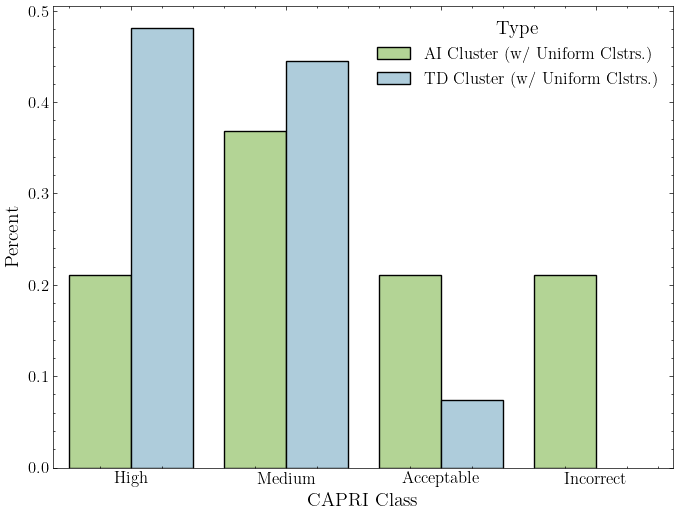

In [902]:
# We want percentages of CAPRI Classes
perc2 = plotdockq.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc2

# Make the CAPRI Class categorical
perc2['capri'] = pd.Categorical(perc2['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=perc2, x='capri', y='Percent', hue='Type', palette=colors, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=14)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize='14', fontsize='12')

plt.savefig('./project_pipeline/data/figures/clust_dockq_histograms.png', bbox_inches='tight', dpi=300)

In [900]:
# min_nou = min_nou.drop(columns=['Type'])
# mdmin_nou = mdmin_nou.drop(columns=['Type'])

min_dockq_nou = pd.merge(min_nou, ai2, on=['PDB', 'Cluster'], how='inner')
mdmin_dockq_nou = pd.merge(mdmin_nou, md2, on=['PDB', 'Cluster'], how='inner')

min_dockq_nou['Type'] = 'AI Cluster (w/o Uniform Clstrs.)'
mdmin_dockq_nou['Type'] = 'TD Cluster (w/o Uniform Clstrs.)'

plotdockq2 = pd.concat([min_dockq_nou, mdmin_dockq_nou], ignore_index=True)
plotdockq2.shape

(57, 38)

/tmp/ipykernel_2592195/1563371120.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


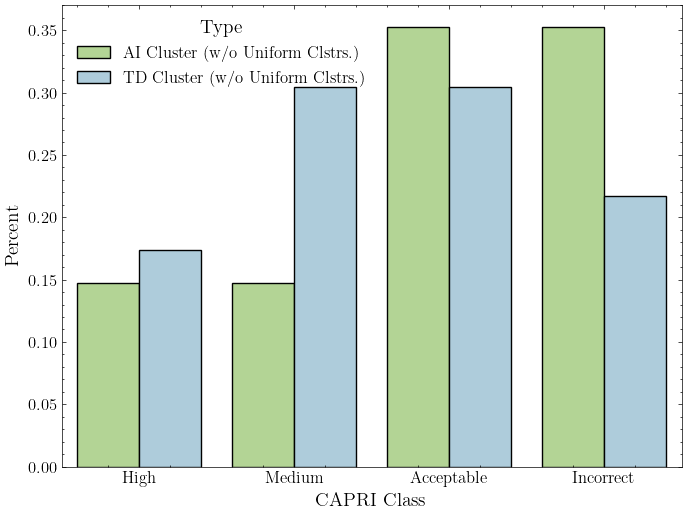

In [903]:
# We want percentages of CAPRI Classes
perc3 = plotdockq2.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc3

# Make the CAPRI Class categorical
perc3['capri'] = pd.Categorical(perc3['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=perc3, x='capri', y='Percent', hue='Type', palette=colors, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=14)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize='14', fontsize='12')

plt.savefig('./project_pipeline/data/figures/clust_nou_dockq_histograms.png', bbox_inches='tight', dpi=300)

In [907]:
perc3

,Type,capri,Percent
0,AI Cluster (w/o Uniform Clstrs.),Acceptable,0.352941
1,AI Cluster (w/o Uniform Clstrs.),Incorrect,0.352941
2,AI Cluster (w/o Uniform Clstrs.),High,0.147059
3,AI Cluster (w/o Uniform Clstrs.),Medium,0.147059
4,TD Cluster (w/o Uniform Clstrs.),Acceptable,0.304348
5,TD Cluster (w/o Uniform Clstrs.),Medium,0.304348
6,TD Cluster (w/o Uniform Clstrs.),Incorrect,0.217391
7,TD Cluster (w/o Uniform Clstrs.),High,0.173913


#### Plotting TD cluster vs AI cluster

In [410]:
to_plot_clust = to_plot_clust.rename(columns={imfd: imfdd1d2,
                                               im: imd1, fd: '$_{fd}$RMSD/$_{d2}$RMSD'})
mdto_plot_clust = mdto_plot_clust.rename(columns={d1d2: imfdd1d2,
                                                  d1: imd1,
                                                  d2: '$_{fd}$RMSD/$_{d2}$RMSD'})

In [411]:
to_plot_clust['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
mdto_plot_clust['Type'] = 'TD Cluster (w/ Uniform Clstrs.)'

to_plot3 = pd.concat([to_plot_clust, mdto_plot_clust])
to_plot3 = to_plot3[['UniProt', 'PDB', 'Type', 'Cluster', 'gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', 
                     imfdd1d2]]
to_plot3.head()

,UniProt,PDB,Type,Cluster,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD
0,B5XAZ0,7bfl,AI Cluster (w/ Uniform Clstrs.),U10-006,2.45,0.642,2.607,0.767
1,D2AJU0,6lol,AI Cluster (w/ Uniform Clstrs.),U10-005,7.466,1.714,5.764,9.835
2,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),005,15.676,3.737,4.532,5.99
3,O60741,5u6o,AI Cluster (w/ Uniform Clstrs.),U10-003,23.197,16.185,12.563,21.264
4,O76074,3lfv,AI Cluster (w/ Uniform Clstrs.),U100-004,7.663,2.273,2.899,5.267


In [412]:
# Melt the data for plotting
to_plot3_melt = pd.melt(to_plot3, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot3_melt['RMSD'] = to_plot3_melt['RMSD'].astype(float)
to_plot3_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,B5XAZ0,7bfl,AI Cluster (w/ Uniform Clstrs.),U10-006,gRMSD,2.450
1,D2AJU0,6lol,AI Cluster (w/ Uniform Clstrs.),U10-005,gRMSD,7.466
2,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),005,gRMSD,15.676
3,O60741,5u6o,AI Cluster (w/ Uniform Clstrs.),U10-003,gRMSD,23.197
4,O76074,3lfv,AI Cluster (w/ Uniform Clstrs.),U100-004,gRMSD,7.663


In [413]:
to_plot3['Type'].value_counts()

AI Cluster (w/ Uniform Clstrs.)    38
TD Cluster (w/ Uniform Clstrs.)    27
Name: Type, dtype: int64

/tmp/ipykernel_2592195/1958138889.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD/$_{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.373e-05 U_stat=8.250e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:4.501e-05 U_stat=8.200e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:5.045e-05 U_stat=8.180e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:5.652e-05 U_stat=8.160e+02


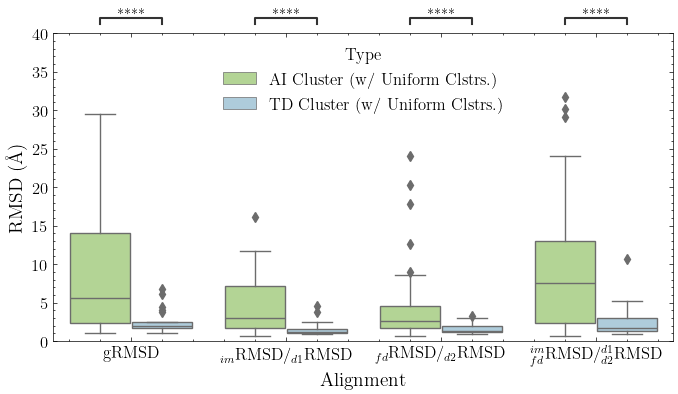

In [414]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=to_plot3_melt, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('gRMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imd1, 'AI Cluster (w/ Uniform Clstrs.)'), (imd1, 'TD Cluster (w/ Uniform Clstrs.)')],
         [('$_{fd}$RMSD/$_{d2}$RMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('$_{fd}$RMSD/$_{d2}$RMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imfdd1d2, 'AI Cluster (w/ Uniform Clstrs.)'), (imfdd1d2, 'TD Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', imfdd1d2]
annotator = Annotator(ax, pairs, data=to_plot3_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/ai_vs_md_clust.png', dpi=500, bbox_inches='tight')

Now compare for AI structures with two conformations.

In [415]:
to_plot_clust2 = to_plot_clust2.rename(columns={imfd: imfdd1d2,
                                               im: imd1, fd: '$_{fd}$RMSD/$_{d2}$RMSD'})

to_plot_clust2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'

to_plot4 = pd.concat([to_plot_clust2, mdto_plot_clust])
to_plot4 = to_plot4[['UniProt', 'PDB', 'Type', 'Cluster', 'gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', 
                     imfdd1d2]]
to_plot4.head()

# Melt the data for plotting
to_plot4_melt = pd.melt(to_plot4, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot4_melt['RMSD'] = to_plot4_melt['RMSD'].astype(float)
to_plot4_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),005,gRMSD,15.676
1,P00579,4zh3,AI Cluster (w/ Uniform Clstrs.),U10-002,gRMSD,29.500
2,P07038,7nxf,AI Cluster (w/ Uniform Clstrs.),U100-008,gRMSD,5.250
3,P12931,7yqe,AI Cluster (w/ Uniform Clstrs.),U10-007,gRMSD,1.402
4,P21333,2j3s,AI Cluster (w/ Uniform Clstrs.),U10-003,gRMSD,14.661


/tmp/ipykernel_2592195/3276397309.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD/$_{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.036e-04 U_stat=3.710e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.273e-04 U_stat=3.690e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.956e-04 U_stat=3.500e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.149e-04 U_stat=3.700e+02


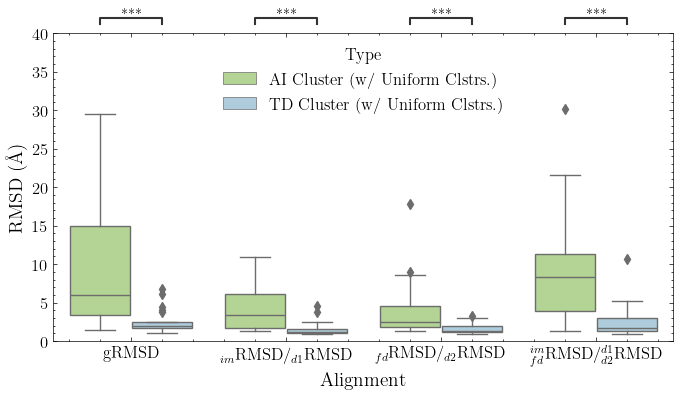

In [416]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=to_plot4_melt, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('gRMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imd1, 'AI Cluster (w/ Uniform Clstrs.)'), (imd1, 'TD Cluster (w/ Uniform Clstrs.)')],
         [('$_{fd}$RMSD/$_{d2}$RMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('$_{fd}$RMSD/$_{d2}$RMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imfdd1d2, 'AI Cluster (w/ Uniform Clstrs.)'), (imfdd1d2, 'TD Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', imfdd1d2]
annotator = Annotator(ax, pairs, data=to_plot4_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/two_conf_ai_vs_md_clust.png', dpi=500, bbox_inches='tight')

## pLDDT of Clusters

In [1018]:
clAuto = pd.read_csv('./project_pipeline/data/ai_cluster_pLDDT.tsv', sep='\t')
clMulti = pd.read_csv('./project_pipeline/data/md_cluster_pLDDT.tsv', sep='\t')
clAuto = clAuto.drop(columns=['Unnamed: 0'])
clMulti['cluster'] = clMulti.apply(lambda x: x['cf_filename'].split('_')[1], axis=1)
clMulti.head()

clAuto = clAuto.rename(columns={'uniprot': 'UniProt', 'cluster': 'Cluster'})
clMulti = clMulti.rename(columns={'uniprot': 'UniProt', 'cluster': 'Cluster'})

In [1019]:
clAuto.head()

,UniProt,pdb,region_1,region_2,af_filename,chain,Cluster,cf_filename,complex_mean_plddt,r1_mean_plddt,r2_mean_plddt
0,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,004,P04637_004_unrelaxed_rank_001_alphafold2_multi...,55.981,41.231,68.223
1,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,000,P04637_000_unrelaxed_rank_001_alphafold2_multi...,54.921,35.245,60.018
2,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,015,P04637_015_unrelaxed_rank_001_alphafold2_multi...,59.944,35.621,77.713
3,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,009,P04637_009_unrelaxed_rank_001_alphafold2_multi...,55.534,42.184,64.641
4,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,U100-003,P04637_U100-003_unrelaxed_rank_001_alphafold2_...,76.372,33.071,95.035


In [1020]:
afAutosub = afAuto[afAuto['uniprot'].isin(clust_uniprots)].drop_duplicates()
afMultisub = afMulti[afMulti['uniprot'].isin(mdclust_uniprots)].drop_duplicates()

In [1021]:
clAuto = clAuto.drop(columns=['cf_filename', 'pdb', 'af_filename', 'chain']).drop_duplicates().reset_index(drop=True)
clMulti = clMulti.drop(columns=['cf_filename', 'af_filename']).drop_duplicates().reset_index(drop=True)

In [1022]:
# Get the pLDDT of only the best clusters
bestclAuto = pd.merge(min_clust[['UniProt', 'Cluster']], clAuto, on=['UniProt', 'Cluster'], how='inner')
bestclMulti = pd.merge(min_md_clust[['UniProt', 'Cluster']], clMulti, on=['UniProt', 'Cluster'], how='inner')

bestclAuto = bestclAuto.rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})
bestclMulti = bestclMulti.rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})

In [1023]:
bestclAuto = rename_auto_columns(bestclAuto)
bestclMulti = rename_multi_columns(bestclMulti)

afAutosub = rename_auto_columns(afAutosub)
afMultisub = rename_multi_columns(afMultisub)

bestclAuto_p = pivot_cf_df(bestclAuto)
bestclMulti_p = pivot_cf_df(bestclMulti)

bestafAuto_p = pivot_af_df(afAutosub)
bestafMulti_p = pivot_af_df(afMultisub)

bestclAuto_p['type'] = 'AI Cluster (w/ Uniform Clstrs.)'
bestclMulti_p['type'] = 'TD Cluster (w/ Uniform Clstrs.)'

bestafAuto_p['type'] = 'AI Full Depth'
bestafMulti_p['type'] = 'TD Full Depth'

clplddt = pd.concat([bestclAuto_p, bestclMulti_p])
aiplddt = pd.concat([bestafAuto_p, bestclAuto_p])
mdplddt = pd.concat([bestafMulti_p, bestclMulti_p])

In [1024]:
bestafAuto_p['uniprot'].nunique()

38

/tmp/ipykernel_2592195/2551366932.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.418e-01 U_stat=6.300e+02
Global AI_AI Full Depth vs. Global AI_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:2.597e-01 U_stat=6.130e+02
FD_AI Full Depth vs. FD_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:9.544e-01 U_stat=7.280e+02


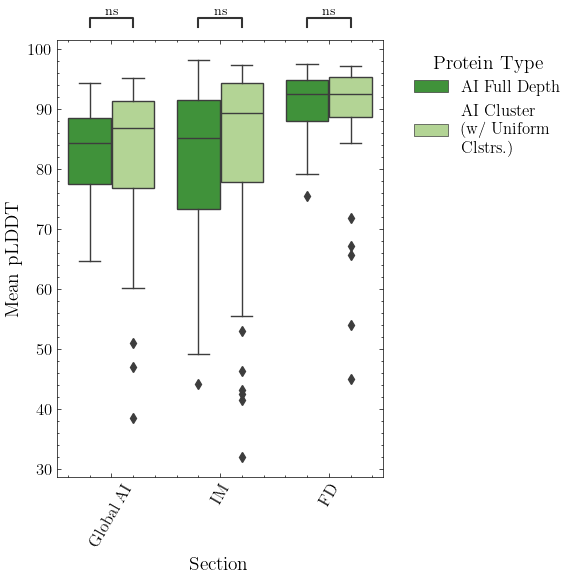

In [1025]:
# AI full depth vs AI cluster
subcat_order = ['Global AI', 'IM', 'FD']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=aiplddt, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
labels = ['AI Full Depth', 'AI Cluster \n (w/ Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
          handles=handles, labels=labels)


# Annotate statistical significance
pairs = [[('Global AI', 'AI Cluster (w/ Uniform Clstrs.)'), ('Global AI', 'AI Full Depth')],
         [('IM', 'AI Cluster (w/ Uniform Clstrs.)'), ('IM', 'AI Full Depth')],
         [('FD', 'AI Cluster (w/ Uniform Clstrs.)'), ('FD', 'AI Full Depth')]]

type_order = ['AI Cluster (w/ Uniform Clstrs.)', 'AI Full Depth']
annotator = Annotator(ax, pairs, data=aiplddt, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_best_cluster_plddt.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2592195/3080496450.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1_TD Full Depth vs. D1_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:2.680e-02 U_stat=4.930e+02
Global TD_TD Full Depth vs. Global TD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:5.221e-01 U_stat=4.020e+02
D2_TD Full Depth vs. D2_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.952e-02 U_stat=4.840e+02


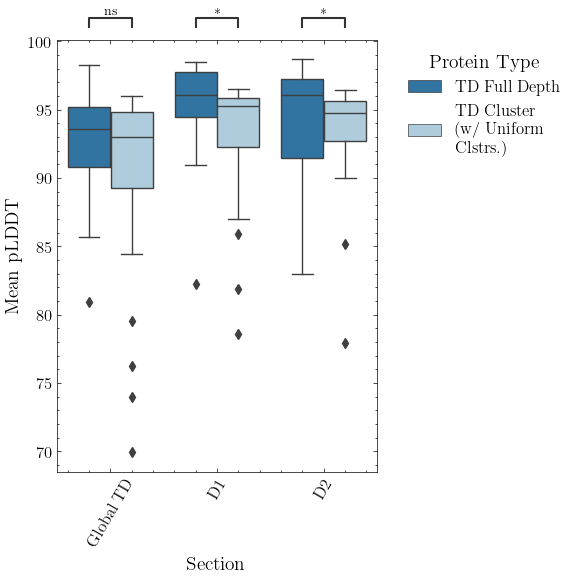

In [1026]:
# AI full depth vs AI cluster
subcat_order = ['Global TD', 'D1', 'D2']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=mdplddt, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
labels = ['TD Full Depth', 'TD Cluster \n (w/ Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
          handles=handles, labels=labels)


# Annotate statistical significance
pairs = [[('Global TD', 'TD Cluster (w/ Uniform Clstrs.)'), ('Global TD', 'TD Full Depth')],
         [('D1', 'TD Cluster (w/ Uniform Clstrs.)'), ('D1', 'TD Full Depth')],
         [('D2', 'TD Cluster (w/ Uniform Clstrs.)'), ('D2', 'TD Full Depth')]]

type_order = ['TD Cluster (w/ Uniform Clstrs.)', 'TD Full Depth']
annotator = Annotator(ax, pairs, data=mdplddt, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/md_best_cluster_plddt.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2592195/2203663596.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_AI Cluster (w/ Uniform Clstrs.) vs. Global TD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.246e-03 U_stat=2.700e+02
IM_AI Cluster (w/ Uniform Clstrs.) vs. D1_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.296e-04 U_stat=2.250e+02
FD_AI Cluster (w/ Uniform Clstrs.) vs. D2_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:4.657e-02 U_stat=3.630e+02


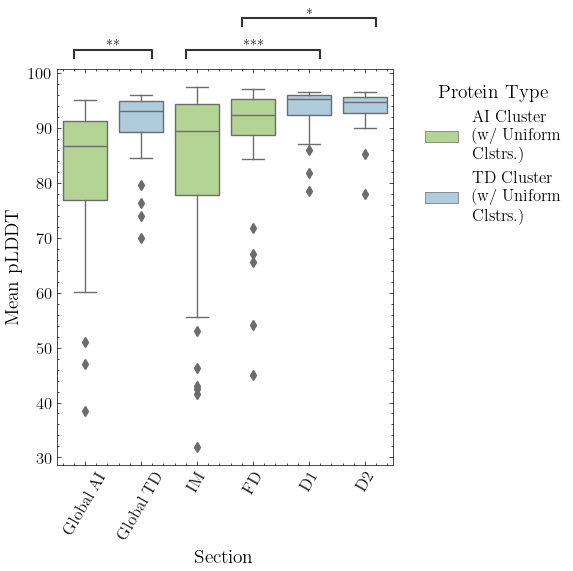

In [973]:
subcat_order = ['Global AI', 'Global TD', 'IM', 'FD', 'D1', 'D2']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=clplddt, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order, dodge=False)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
labels = ['AI Cluster \n (w/ Uniform \n Clstrs.)', 'TD Cluster \n (w/ Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
          handles=handles, labels=labels)


# Annotate statistical significance
pairs = [[('Global AI', 'AI Cluster (w/ Uniform Clstrs.)'), ('Global TD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [('IM', 'AI Cluster (w/ Uniform Clstrs.)'), ('D1', 'TD Cluster (w/ Uniform Clstrs.)')],
         [('FD', 'AI Cluster (w/ Uniform Clstrs.)'), ('D2', 'TD Cluster (w/ Uniform Clstrs.)')]]

type_order = ['AI Cluster (w/ Uniform Clstrs.)', 'TD Cluster (w/ Uniform Clstrs.)']
annotator = Annotator(ax, pairs, data=clplddt, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_md_best_cluster_plddt.png', dpi=300, bbox_inches='tight')

In [1027]:
# Now only the non-uniformly clustered proteins
bestclAuto_nou = pd.merge(min_nou[['UniProt', 'Cluster']], clAuto, on=['UniProt', 'Cluster'], how='inner')
bestclMulti_nou = pd.merge(mdmin_nou[['UniProt', 'Cluster']], clMulti, on=['UniProt', 'Cluster'], how='inner')

bestclAuto_nou = bestclAuto_nou.rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})
bestclMulti_nou = bestclMulti_nou.rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})

bestclAuto_nou = rename_auto_columns(bestclAuto_nou)
bestclMulti_nou = rename_multi_columns(bestclMulti_nou)

bestclAuto_nou_p = pivot_cf_df(bestclAuto_nou)
bestclMulti_nou_p = pivot_cf_df(bestclMulti_nou)

bestclAuto_nou_p['type'] = 'AI Cluster (w/o Uniform Clstrs.)'
bestclMulti_nou_p['type'] = 'TD Cluster (w/o Uniform Clstrs.)'

clplddt_nou = pd.concat([bestclAuto_nou_p, bestclMulti_nou_p])
aiplddt_nou = pd.concat([bestafAuto_p, bestclAuto_nou_p])
mdplddt_nou = pd.concat([bestafMulti_p, bestclMulti_nou_p])

/tmp/ipykernel_2592195/801072980.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.193e-02 U_stat=8.120e+02
Global AI_AI Full Depth vs. Global AI_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.449e-03 U_stat=8.880e+02
FD_AI Full Depth vs. FD_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:5.329e-06 U_stat=1.050e+03


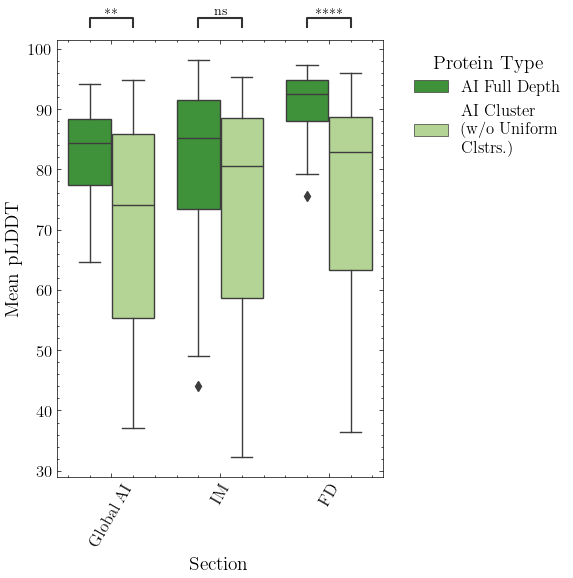

In [1028]:
# AI full depth vs AI cluster
subcat_order = ['Global AI', 'IM', 'FD']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=aiplddt_nou, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
labels = ['AI Full Depth', 'AI Cluster \n (w/o Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
          handles=handles, labels=labels)


# Annotate statistical significance
pairs = [[('Global AI', 'AI Cluster (w/o Uniform Clstrs.)'), ('Global AI', 'AI Full Depth')],
         [('IM', 'AI Cluster (w/o Uniform Clstrs.)'), ('IM', 'AI Full Depth')],
         [('FD', 'AI Cluster (w/o Uniform Clstrs.)'), ('FD', 'AI Full Depth')]]

type_order = ['AI Cluster (w/o Uniform Clstrs.)', 'AI Full Depth']
annotator = Annotator(ax, pairs, data=aiplddt_nou, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_nou_cluster_plddt.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2592195/3609592908.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1_TD Full Depth vs. D1_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.919e-07 U_stat=5.660e+02
Global TD_TD Full Depth vs. Global TD_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.647e-07 U_stat=5.650e+02
D2_TD Full Depth vs. D2_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.849e-05 U_stat=5.310e+02


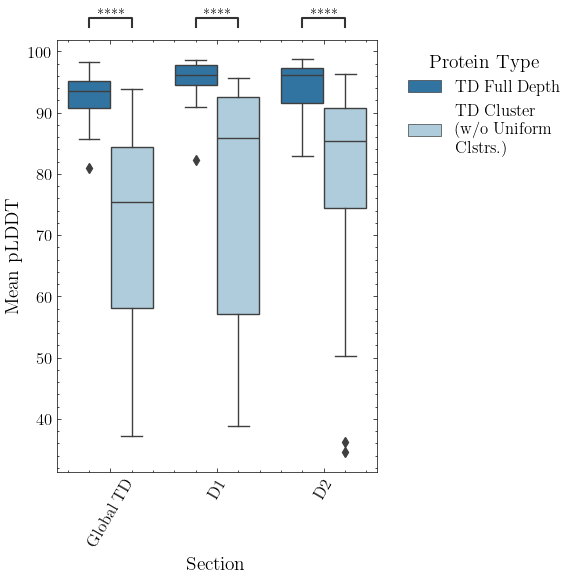

In [1029]:
# AI full depth vs AI cluster
subcat_order = ['Global TD', 'D1', 'D2']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=mdplddt_nou, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
labels = ['TD Full Depth', 'TD Cluster \n (w/o Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
          handles=handles, labels=labels)


# Annotate statistical significance
pairs = [[('Global TD', 'TD Cluster (w/o Uniform Clstrs.)'), ('Global TD', 'TD Full Depth')],
         [('D1', 'TD Cluster (w/o Uniform Clstrs.)'), ('D1', 'TD Full Depth')],
         [('D2', 'TD Cluster (w/o Uniform Clstrs.)'), ('D2', 'TD Full Depth')]]

type_order = ['TD Cluster (w/ Uniform Clstrs.)', 'TD Full Depth']
annotator = Annotator(ax, pairs, data=mdplddt_nou, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/md_nou_cluster_plddt.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2592195/2452469322.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_AI Cluster (w/o Uniform Clstrs.) vs. Global TD_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.511e-01 U_stat=3.710e+02
IM_AI Cluster (w/o Uniform Clstrs.) vs. D1_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:4.207e-01 U_stat=3.410e+02
FD_AI Cluster (w/o Uniform Clstrs.) vs. D2_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.754e-01 U_stat=3.360e+02


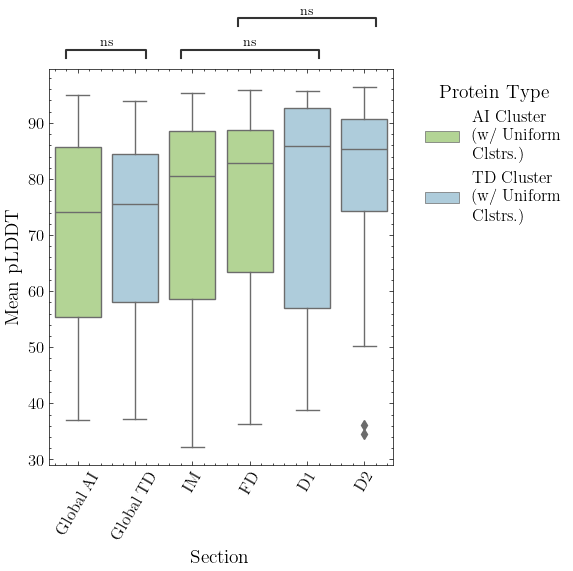

In [972]:
subcat_order = ['Global AI', 'Global TD', 'IM', 'FD', 'D1', 'D2']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=clplddt_nou, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order, dodge=False)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
labels = ['AI Cluster \n (w/ Uniform \n Clstrs.)', 'TD Cluster \n (w/ Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
          handles=handles, labels=labels)


# Annotate statistical significance
pairs = [[('Global AI', 'AI Cluster (w/o Uniform Clstrs.)'), ('Global TD', 'TD Cluster (w/o Uniform Clstrs.)')],
         [('IM', 'AI Cluster (w/o Uniform Clstrs.)'), ('D1', 'TD Cluster (w/o Uniform Clstrs.)')],
         [('FD', 'AI Cluster (w/o Uniform Clstrs.)'), ('D2', 'TD Cluster (w/o Uniform Clstrs.)')]]

type_order = ['AI Cluster (w/o Uniform Clstrs.)', 'TD Cluster (w/o Uniform Clstrs.)']
annotator = Annotator(ax, pairs, data=clplddt_nou, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.xticks(rotation=60)
# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/ai_md_nou_cluster_plddt.png', dpi=300, bbox_inches='tight')

## PAE for Clusters

In [1092]:
df_auto_cl = pd.read_csv('./project_pipeline/data/ai_cluster_pae.tsv', sep='\t').astype('object')
df_multi_cl = pd.read_csv('./project_pipeline/data/md_cluster_pae.tsv', sep='\t').astype('object')

In [1035]:
df_multi_cl.head()

,uniprot,cluster,region_1,region_2,mean_pae_1_1,mean_pae_1_2,mean_pae_2_2
0,D9N168,U10-007,3-169,336-543,3.29,6.401,2.989
1,D9N168,U100-004,3-169,336-543,2.38,4.885,2.823
2,D9N168,U10-005,3-169,336-543,2.812,5.61,3.005
3,D9N168,U100-002,3-169,336-543,2.497,5.082,2.806
4,D9N168,U10-009,3-169,336-543,4.34,7.818,2.91


In [1036]:
print('The number of unique autoinhibitory clusters is ' + str(df_auto_cl.groupby('uniprot')['cluster'].nunique().sum()))
print('The number of unique two-domain clusters is ' + str(df_multi_cl.groupby('uniprot')['cluster'].nunique().sum()))

The number of unique autoinhibitory clusters is 1536
The number of unique two-domain clusters is 2168


In [1093]:
# Reformat all pae dataframe
df_auto_cl = df_auto_cl[['uniprot', 'cluster', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_auto_cl = df_auto_cl.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 'mean_pae_2_2': 'FD', 'uniprot': 'UniProt', 'cluster': 'Cluster'})
best_cl_pae = pd.merge(min_clust[['UniProt', 'Cluster']], df_auto_cl, on=['UniProt', 'Cluster'], how='inner')
best_cl_pae_melt = best_cl_pae.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Get full-depth PAEs for only the cluster proteins
df_pae_melt2 = df_pae_melt[df_pae_melt['uniprot'].isin(clust_uniprots)]

# Reformat the multi dataframe
df_multi_cl = df_multi_cl[['uniprot', 'cluster', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi_cl = df_multi_cl.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 vs D2', 'mean_pae_2_2': 'D2', 'uniprot': 'UniProt', 'cluster': 'Cluster'})
best_multi_cl_pae = pd.merge(min_md_clust[['UniProt', 'Cluster']], df_multi_cl, on=['UniProt', 'Cluster'], how='inner')
best_multi_cl_pae_melt = best_multi_cl_pae.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Get full-depth PAEs for only the md cluster proteins
df_multi_melt2 = df_multi_melt[df_multi_melt['uniprot'].isin(mdclust_uniprots)]

# Add type column
best_cl_pae_melt['type'] = 'AI Cluster (w/ Uniform Clstrs.)'
df_pae_melt2['type'] = 'AI Full Depth'
best_multi_cl_pae_melt['type'] = 'TD Cluster (w/ Uniform Clstrs.)'
df_multi_melt2['type'] = 'TD Full Depth'

# Merge all dataframes
all_ai = pd.concat([df_pae_melt2, best_cl_pae_melt])
all_md = pd.concat([df_multi_melt2, best_multi_cl_pae_melt])

all_ai['mean_pae'] = all_ai['mean_pae'].astype(float)
all_md['mean_pae'] = all_md['mean_pae'].astype(float)

/tmp/ipykernel_2592195/3252188992.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pae_melt2['type'] = 'AI Full Depth'
/tmp/ipykernel_2592195/3252188992.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multi_melt2['type'] = 'TD Full Depth'


In [1067]:
all_md['type'].value_counts()

TD Full Depth    81
TD Cluster       57
Name: type, dtype: int64

/tmp/ipykernel_2592195/2213750551.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.857e-01 U_stat=3.260e+02
FD_AI Full Depth vs. FD_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.060e-01 U_stat=3.200e+02
IM vs FD_AI Full Depth vs. IM vs FD_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.948e-01 U_stat=2.930e+02


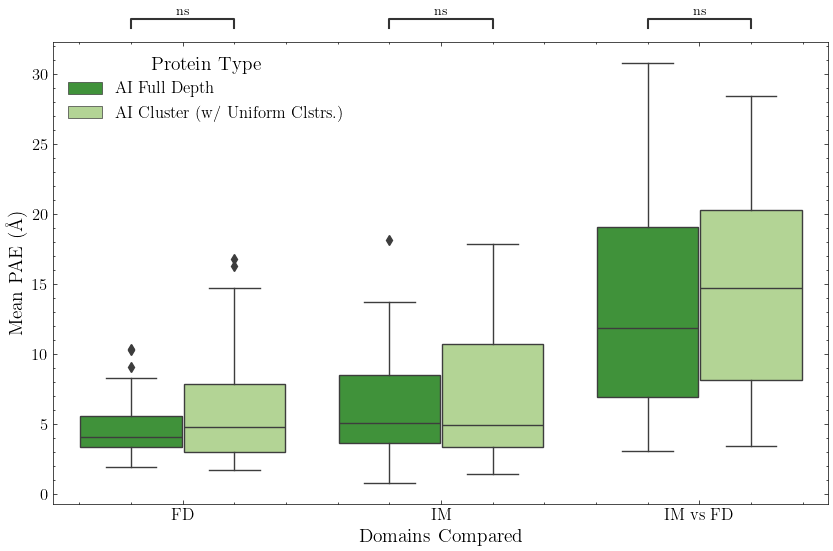

In [1094]:
region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_ai, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('FD', 'AI Full Depth'), ('FD', 'AI Cluster (w/ Uniform Clstrs.)')],
         [('IM', 'AI Full Depth'), ('IM', 'AI Cluster (w/ Uniform Clstrs.)')],
         [('IM vs FD', 'AI Full Depth'), ('IM vs FD', 'AI Cluster (w/ Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_ai, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/ai_cluster_v_fd_pae_annotated.png')

/tmp/ipykernel_2592195/423326846.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1_TD Full Depth vs. D1_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.735e-02 U_stat=1.740e+02
D2_TD Full Depth vs. D2_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.718e-01 U_stat=2.700e+02
D1 vs D2_TD Full Depth vs. D1 vs D2_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.736e-01 U_stat=1.950e+02


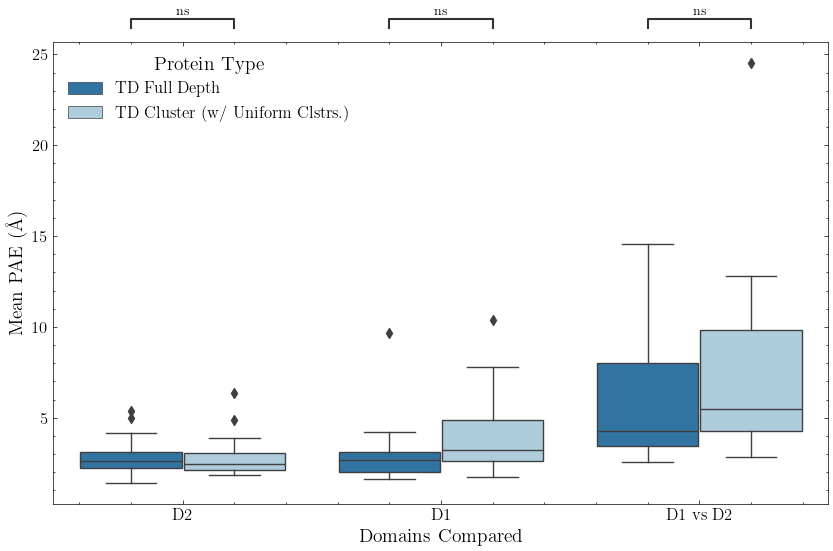

In [1095]:
region_order = ['D2', 'D1', 'D1 vs D2']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_md, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('D2', 'TD Full Depth'), ('D2', 'TD Cluster (w/ Uniform Clstrs.)')],
         [('D1', 'TD Full Depth'), ('D1', 'TD Cluster (w/ Uniform Clstrs.)')],
         [('D1 vs D2', 'TD Full Depth'), ('D1 vs D2', 'TD Cluster (w/ Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_md, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/md_cluster_v_fd_pae_annotated.png')

In [1096]:
# Non-uniformly clustered proteins
best_cl_pae_nou = pd.merge(min_nou[['UniProt', 'Cluster']], df_auto_cl, on=['UniProt', 'Cluster'], how='inner')
best_cl_pae_nou_melt = best_cl_pae_nou.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Multi-domain
best_multi_cl_pae_nou = pd.merge(mdmin_nou[['UniProt', 'Cluster']], df_multi_cl, on=['UniProt', 'Cluster'], how='inner')
best_multi_cl_pae_nou_melt = best_multi_cl_pae_nou.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
best_cl_pae_nou_melt['type'] = 'AI Cluster (w/o Uniform Clstrs.)'
best_multi_cl_pae_nou_melt['type'] = 'TD Cluster (w/o Uniform Clstrs.)'

# Merge all dataframes
all_ai_nou = pd.concat([df_pae_melt2, best_cl_pae_nou_melt])
all_md_nou = pd.concat([df_multi_melt2, best_multi_cl_pae_nou_melt])

all_ai_nou['mean_pae'] = all_ai_nou['mean_pae'].astype(float)
all_md_nou['mean_pae'] = all_md_nou['mean_pae'].astype(float)

In [1072]:
all_ai_nou.shape

(162, 6)

/tmp/ipykernel_2592195/3572932985.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.421e-01 U_stat=2.260e+02
FD_AI Full Depth vs. FD_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:8.148e-06 U_stat=6.800e+01
IM vs FD_AI Full Depth vs. IM vs FD_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:8.227e-03 U_stat=1.640e+02


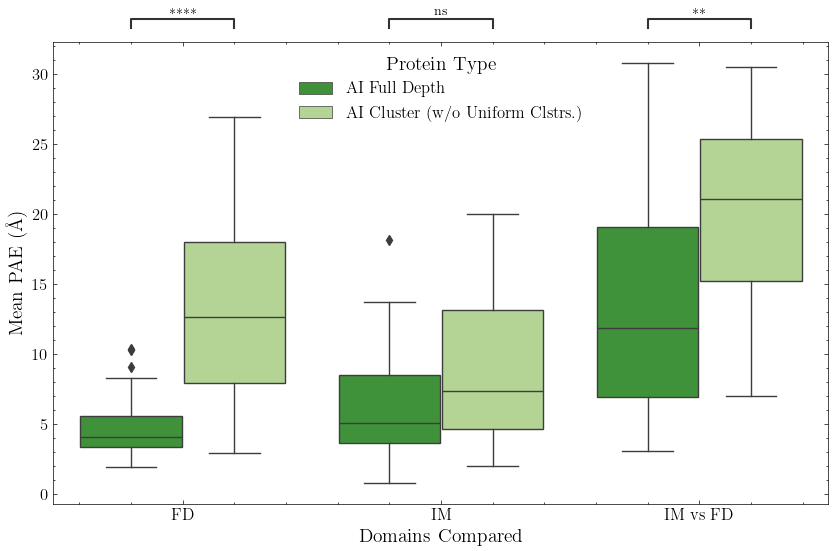

In [1099]:
region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_ai_nou, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('FD', 'AI Full Depth'), ('FD', 'AI Cluster (w/o Uniform Clstrs.)')],
         [('IM', 'AI Full Depth'), ('IM', 'AI Cluster (w/o Uniform Clstrs.)')],
         [('IM vs FD', 'AI Full Depth'), ('IM vs FD', 'AI Cluster (w/o Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_ai_nou, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/ai_cluster_v_fd_pae_nou.png')

/tmp/ipykernel_2592195/883104118.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1_TD Full Depth vs. D1_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:5.514e-05 U_stat=5.500e+01
D2_TD Full Depth vs. D2_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.627e-04 U_stat=8.000e+01
D1 vs D2_TD Full Depth vs. D1 vs D2_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.906e-04 U_stat=6.700e+01


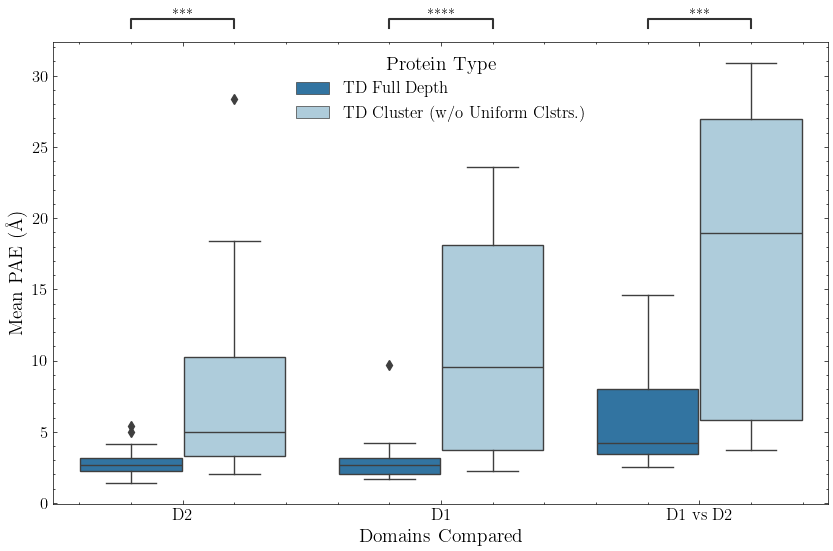

In [1100]:
region_order = ['D2', 'D1', 'D1 vs D2']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_md_nou, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('D2', 'TD Full Depth'), ('D2', 'TD Cluster (w/o Uniform Clstrs.)')],
         [('D1', 'TD Full Depth'), ('D1', 'TD Cluster (w/o Uniform Clstrs.)')],
         [('D1 vs D2', 'TD Full Depth'), ('D1 vs D2', 'TD Cluster (w/o Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_md_nou, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/md_cluster_v_fd_pae_nou.png')

To make a table comparing cluster $_{im}$RMSDs with full-depth $_{im}$RMSDs, we'll rename some of the columns

In [429]:
to_table_nou = to_plot_nou[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

to_table_class = to_plot_class2[['UniProt', 'PDB', 'gRMSD', im, fd, imfd, 'Type']]

to_table_nou = to_table_nou.rename(columns={imfd: 'Cluster $_{fd}^{im}$RMSD', 'gRMSD': 'Cluster gRMSD'})

to_table_class = to_table_class.rename(columns={imfd: 'Full Depth $_{fd}^{im}$RMSD', 'gRMSD': 'Full Depth gRMSD'})

to_table_nou = to_table_nou[['UniProt', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD']]

to_table_class = to_table_class[['UniProt', 'Full Depth gRMSD', 'Full Depth $_{fd}^{im}$RMSD']]

to_table = pd.merge(to_table_nou, to_table_class, on=['UniProt'], how='inner')

to_table['Full Depth gRMSD'] = to_table['Full Depth gRMSD'].astype(float)
to_table['Cluster gRMSD'] = to_table['Cluster gRMSD'].astype(float)
to_table['Cluster $_{fd}^{im}$RMSD'] = to_table['Cluster $_{fd}^{im}$RMSD'].astype(float)
to_table['Full Depth $_{fd}^{im}$RMSD'] = to_table['Full Depth $_{fd}^{im}$RMSD'].astype(float)

In [430]:
cols = to_table.columns.tolist()
cols = ['UniProt', 'Full Depth gRMSD', 'Cluster gRMSD', 'Full Depth $_{fd}^{im}$RMSD', 'Cluster $_{fd}^{im}$RMSD']

to_table = to_table[cols]

This is the table with non-uniform clusters.

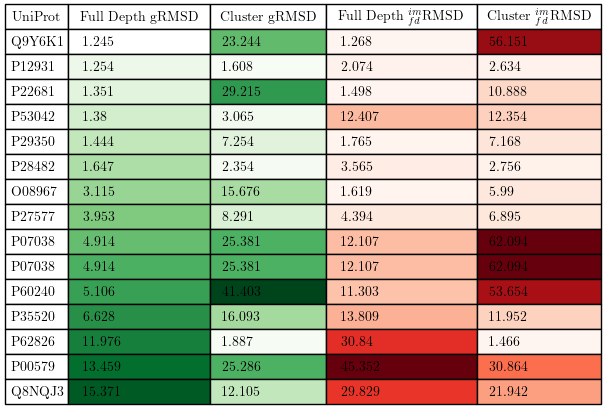

<Figure size 350x262.5 with 0 Axes>

In [1101]:
fig, ax = plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')

to_table = to_table.sort_values('Full Depth gRMSD')

table = ax.table(cellText=to_table.values,
                  colLabels=to_table.columns,
                  cellLoc = 'left', loc='center')
table.auto_set_column_width(col=list(range(len(to_table.columns))))
table.scale(1, 1.5)

bcmap = sns.mpl_palette('Greens', len(to_table['Full Depth gRMSD'].unique()))
for idx, b in enumerate(bcmap):
    table[(idx + 2, 1)].set_facecolor(b)

from matplotlib import cm
vals = to_table['Cluster gRMSD'].values
normal = cm.colors.Normalize(vals.min(), vals.max())
bcmap2 = plt.cm.Greens(normal(vals))

for idx, bb in enumerate(bcmap2):
    table[(idx + 1, 2)].set_facecolor(bb)

vals2 = to_table['Full Depth $_{fd}^{im}$RMSD'].values
normal2 = cm.colors.Normalize(vals2.min(), vals2.max())
bcmap3 = plt.cm.Reds(normal2(vals2))

for idx, bbb in enumerate(bcmap3):
    table[(idx+1, 3)].set_facecolor(bbb)

vals3 = to_table['Cluster $_{fd}^{im}$RMSD'].values
normal3 = cm.colors.Normalize(vals3.min(), vals3.max())
bcmap4 = plt.cm.Reds(normal3(vals3))

for idx, bbbb in enumerate(bcmap4):
    table[(idx+1, 4)].set_facecolor(bbbb)

plt.show()

plt.savefig('./project_pipeline/data/figures/full_depth_vs_no_u_cluster_table.png', dpi=300, bbox_inches='tight')

What about including uniform clusters?

In [432]:
to_table_clust = min_clust[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

to_table_clust = to_table_clust.rename(columns={imfd: 'Cluster $_{fd}^{im}$RMSD', 'gRMSD': 'Cluster gRMSD'})

to_table_clust = to_table_clust[['UniProt', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD']]

to_table2 = pd.merge(to_table_clust, to_table_class, on=['UniProt'], how='inner')

to_table2['Full Depth gRMSD'] = to_table2['Full Depth gRMSD'].astype(float)
to_table2['Cluster gRMSD'] = to_table2['Cluster gRMSD'].astype(float)
to_table2['Cluster $_{fd}^{im}$RMSD'] = to_table2['Cluster $_{fd}^{im}$RMSD'].astype(float)
to_table2['Full Depth $_{fd}^{im}$RMSD'] = to_table2['Full Depth $_{fd}^{im}$RMSD'].astype(float)

In [433]:
to_table2 = to_table2[cols]

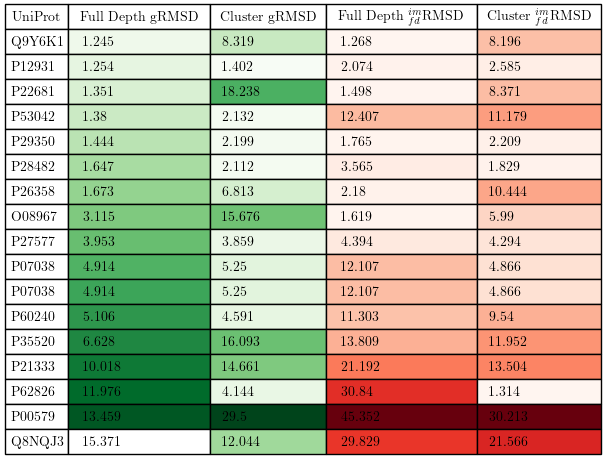

<Figure size 350x262.5 with 0 Axes>

In [434]:
fig, ax = plt.subplots(1,1)

ax.axis('tight')
ax.axis('off')

to_table2f = to_table2.sort_values('Full Depth gRMSD')

table = ax.table(cellText=to_table2f.values,
                    colLabels=to_table2f.columns,
                    cellLoc = 'left', loc='center')
table.auto_set_column_width(col=list(range(len(to_table2f.columns))))
table.scale(1, 1.5)

bcmp = sns.mpl_palette('Greens', len(to_table2f['Full Depth gRMSD'].unique()))
for idx, b in enumerate(bcmp):
    table[(idx + 1, 1)].set_facecolor(b)

val = to_table2f['Cluster gRMSD'].values
norml = cm.colors.Normalize(val.min(), val.max())
bcmp2 = plt.cm.Greens(norml(val))

for idx, bb in enumerate(bcmp2):
    table[(idx + 1, 2)].set_facecolor(bb)

val2 = to_table2f['Full Depth $_{fd}^{im}$RMSD'].values
norml2 = cm.colors.Normalize(val2.min(), val2.max())
bcmp3 = plt.cm.Reds(norml2(val2))

for idx, bbb in enumerate(bcmp3):
    table[(idx+1, 3)].set_facecolor(bbb)

val3 = to_table2f['Cluster $_{fd}^{im}$RMSD'].values
norml3 = cm.colors.Normalize(val3.min(), val3.max())
bcmp4 = plt.cm.Reds(norml3(val3))

for idx, bbbb in enumerate(bcmp4):
    table[(idx+1, 4)].set_facecolor(bbbb)

plt.show()

plt.savefig('./project_pipeline/data/figures/full_depth_vs_cluster_table.png', dpi=300, bbox_inches='tight')

Let's plot the above

In [435]:
# First we have to adjust things a little
to_plot_cl = to_table2[['UniProt', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD']]
to_plot_cl = to_plot_cl.rename(columns={'Cluster gRMSD': 'gRMSD', 'Cluster $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
to_plot_cl['Type'] = 'Cluster'



to_plot_fd = to_table2[['UniProt', 'Full Depth gRMSD', 'Full Depth $_{fd}^{im}$RMSD']]
to_plot_fd = to_plot_fd.rename(columns={'Full Depth gRMSD': 'gRMSD', 'Full Depth $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
to_plot_fd['Type'] = 'Full Depth'

plot_best_fd_clst = pd.concat([to_plot_fd, to_plot_cl])

In [436]:
plot_best_fd_clst

,UniProt,gRMSD,$_{fd}^{im}$RMSD,Type
0,O08967,3.115,1.619,Full Depth
1,P00579,13.459,45.352,Full Depth
2,P07038,4.914,12.107,Full Depth
3,P07038,4.914,12.107,Full Depth
4,P12931,1.254,2.074,Full Depth
5,P21333,10.018,21.192,Full Depth
6,P22681,1.351,1.498,Full Depth
7,P26358,1.673,2.180,Full Depth
8,P27577,3.953,4.394,Full Depth
9,P28482,1.647,3.565,Full Depth


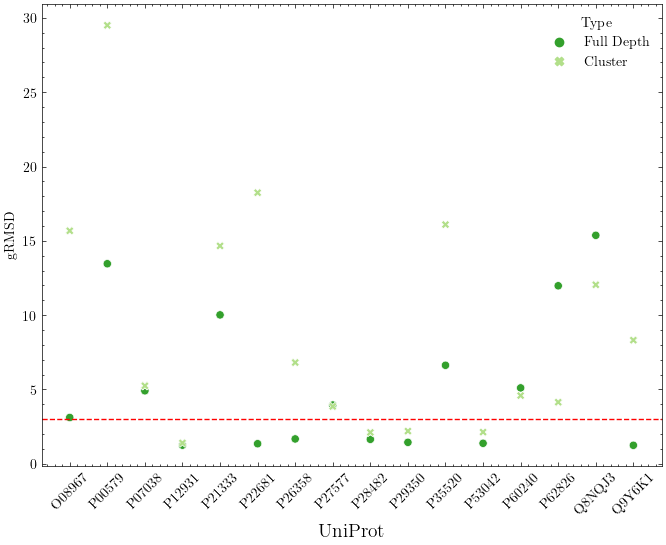

In [437]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x='UniProt', y='gRMSD', data=plot_best_fd_clst, hue='Type', style='Type', palette=colors, ax=ax)
ax.set_xlabel('UniProt', fontsize=14)
plt.xticks(rotation=45)
plt.axhline(y=3, color='r', linestyle='--')

plt.savefig('./project_pipeline/data/figures/best_fd_clst_grmsd.png', dpi=300, bbox_inches='tight')

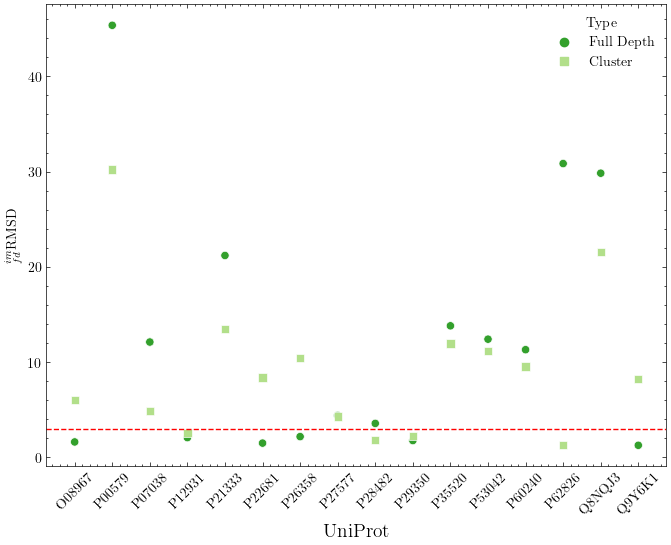

In [438]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x='UniProt', y=imfd, data=plot_best_fd_clst, hue='Type', style='Type', palette=colors, ax=ax,
                markers=['o', 's'])
ax.set_xlabel('UniProt', fontsize=14)
plt.xticks(rotation=45)
plt.axhline(y=3, color='r', linestyle='--')

plt.savefig('./project_pipeline/data/figures/best_fd_clst_imfd.png', dpi=300, bbox_inches='tight')

## Figuring out if any clusters switch state from the full-depth.

In [439]:
minimum_cl.head()

,UniProt,gRMSD,PDB,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Type
0,A0A0R4I961,1.450,6gtv,0.929,1.673,1.135,Autoinhibitory
1,B5XAZ0,2.591,7bfl,0.656,2.760,0.807,Autoinhibitory
2,D2AJU0,3.539,6lol,0.945,2.829,7.860,Autoinhibitory
3,O00571,2.074,7liu,1.660,2.105,1.984,Autoinhibitory
4,O08722,0.922,3g5b,0.872,0.959,0.927,Autoinhibitory


In [1104]:
two_conf_prots = to_table_class['UniProt'].unique().tolist()
two_conf = cl[cl['uniprot'].isin(two_conf_prots)]
fd_pdbs = two_conf['pdb'].unique().tolist()
two_conf

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,chain,af_filename,1_aligned
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.000000,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif,3.288
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.000000,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif,5.41
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.000000,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif,5.41
5,Q8NQJ3,2kb3,1-40,68-117,15.371,97.5,100.000000,2.552,29.829,Autoinhibited,Closed,Corynebacterium glutamicum,['2008-11-20'],NaN,A,F-Q8NQJ3-F1-model_v3.cif,17.161
6,Q8NQJ3,2kb4,1-40,68-117,30.770,100.0,100.000000,2.450,61.982,Active,Open,Corynebacterium glutamicum,['2008-11-20'],NaN,A,F-Q8NQJ3-F1-model_v3.cif,10.374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,O08967,2r0d,"251-265,383-395",77-206,3.115,100.0,100.000000,0.894,1.619,Autoinhibited,Closed,Mus musculus,['2007-08-18'],NaN,A,F-O08967-F1-model_v3.cif,1.433
853,O08967,6bbp,"251-265,383-395",77-206,24.061,100.0,100.000000,0.925,51.878,Active,Closed,Mus musculus,['2017-10-19'],NaN,A,F-O08967-F1-model_v3.cif,3.728
854,O08967,6bbq,"251-265,383-395",77-206,24.786,100.0,100.000000,0.926,54.034,Active,Closed,Mus musculus,['2017-10-19'],NaN,A,F-O08967-F1-model_v3.cif,4.621
883,P53042,4ja7,28-129,"495-499,200-494",1.380,100.0,99.333333,1.348,12.407,Autoinhibited,Closed,Rattus norvegicus,['2013-02-18'],NaN,A,F-P53042-F1-model_v3.cif,1.355


In [1126]:
best_clust_per_pdb = clust.sort_values(imfd).groupby('PDB').first().reset_index()
best_clust_per_pdb = best_clust_per_pdb[['PDB', 'Cluster', 'UniProt', 'gRMSD', imfd]].rename(columns={'gRMSD': 'Cluster gRMSD', imfd: 'Cluster $_{fd}^{im}$RMSD'})

full_depth = cl[['uniprot', 'pdb', 'state', 'conformation', 'complex_rmsd', '2_comp']]
full_depth = full_depth.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'complex_rmsd': 'FD gRMSD', '2_comp': 'FD $_{fd}^{im}$RMSD'})

best = pd.merge(best_clust_per_pdb, full_depth, on=['UniProt', 'PDB'], how='inner')

In [1163]:
accurate_fd_imfd = best[best['FD $_{fd}^{im}$RMSD'] <= 3]

accurate_cluster_imfd = best[best['Cluster $_{fd}^{im}$RMSD'] <= 3]

accurate_fd_grmsd = best[best['FD gRMSD'] <= 3]

accurate_cluster_grmsd = best[best['Cluster gRMSD'] <= 3]

acc = pd.concat([accurate_fd_imfd, accurate_cluster_imfd, accurate_fd_grmsd, accurate_cluster_grmsd]).drop_duplicates().reset_index(drop=True)

In [1165]:
acc[acc['UniProt'] == 'P12931']

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD
4,2h8h,U100-003,P12931,3.746,7.940,Autoinhibited,Closed,1.346,2.700
49,4k11,U100-003,P12931,3.758,6.714,Autoinhibited,Closed,1.254,2.074
139,7yqe,U10-007,P12931,1.402,2.585,Autoinhibited,Closed,2.092,6.031
145,1fmk,U100-001,P12931,2.972,5.604,Autoinhibited,Closed,1.857,7.045
146,1ksw,U100-003,P12931,3.798,12.614,Autoinhibited,Closed,1.767,5.018
152,2src,U100-003,P12931,3.821,12.483,Autoinhibited,Closed,1.693,5.354


In [1149]:
best[(best['UniProt'] == 'P12931')]

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD
2,1fmk,U100-001,P12931,2.972,5.604,Autoinhibited,Closed,1.857,7.045
8,1ksw,U100-003,P12931,3.798,12.614,Autoinhibited,Closed,1.767,5.018
21,1y57,028,P12931,19.964,26.474,Active,Closed,24.076,47.288
23,2h8h,U100-003,P12931,3.746,7.940,Autoinhibited,Closed,1.346,2.700
37,2src,U100-003,P12931,3.821,12.483,Autoinhibited,Closed,1.693,5.354
127,4k11,U100-003,P12931,3.758,6.714,Autoinhibited,Closed,1.254,2.074
354,7yqe,U10-007,P12931,1.402,2.585,Autoinhibited,Closed,2.092,6.031


In [1145]:
best[(best['FD $_{fd}^{im}$RMSD'] <= 3) & (best['Cluster $_{fd}^{im}$RMSD'] <= 3)]['UniProt'].value_counts()

Q02750    69
Q96BN8     9
P31016     2
B5XAZ0     2
P32527     1
Q3KK31     1
P29350     1
Q8RT31     1
Q6GQQ9     1
Name: UniProt, dtype: int64

In [1168]:
best = pd.read_csv('./project_pipeline/data/best.csv').astype('object')
best.head()

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD,two_state,two_conf
0,7bfk,13,B5XAZ0,3.197,0.815,Autoinhibited,Closed,4.781,0.965,False,False
1,7bfl,U10-006,B5XAZ0,2.45,0.767,Autoinhibited,Closed,2.591,0.807,False,False
2,6lol,U10-005,D2AJU0,7.466,9.835,Autoinhibited,Closed,3.539,7.86,False,False
3,2r09,5,O08967,15.556,6.143,Autoinhibited,Closed,3.179,1.593,True,True
4,2r0d,5,O08967,15.676,5.99,Autoinhibited,Closed,3.115,1.619,True,True


In [1184]:
best_grmsd = best.sort_values('FD $_{fd}^{im}$RMSD').groupby(['UniProt', 'state']).head(1)
best_imfd = best.sort_values('FD $_{fd}^{im}$RMSD').groupby(['UniProt', 'state']).head(1)

best_grmsd.sort_values('UniProt')

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD,two_state,two_conf
1,7bfl,U10-006,B5XAZ0,2.45,0.767,Autoinhibited,Closed,2.591,0.807,False,False
2,6lol,U10-005,D2AJU0,7.466,9.835,Autoinhibited,Closed,3.539,7.86,False,False
5,6bbp,U100-004,O08967,13.809,15.237,Active,Closed,24.061,51.878,True,True
3,2r09,5,O08967,15.556,6.143,Autoinhibited,Closed,3.179,1.593,True,True
8,5u6p,U10-004,O60741,21.302,21.721,Active,Closed,1.182,1.29,True,False
7,5u6o,U10-003,O60741,23.197,21.264,Autoinhibited,Closed,1.516,2.148,True,False
11,3lfv,U100-004,O76074,7.663,5.267,Autoinhibited,Closed,3.163,3.791,False,False
13,1opk,U10-006,P00520,25.012,31.702,Autoinhibited,Closed,1.679,1.654,False,False
14,2ptk,14,P00523,6.073,16.925,Autoinhibited,Closed,1.737,3.093,False,False
16,4llg,U10-002,P00579,29.77,31.666,Active,Open,13.459,45.352,False,False


In [442]:
two_conf_clust = min_clust[min_clust['UniProt'].isin(two_conf_prots)]
cl_pdbs = two_conf_clust['PDB'].unique().tolist()
two_conf_clust.shape

(16, 25)

Get the best clusters for the full-depth PDBs

In [443]:
match_fd = clust[clust['PDB'].isin(fd_pdbs)]

# Get the minimum of them
min_match_fd = match_fd.groupby('UniProt')[imfd].min()
min_match_fd = pd.merge(min_match_fd, match_fd, on=['UniProt', imfd], how='inner')

# Clean up the columns
min_match_fd = min_match_fd[['UniProt', 'PDB', imfd, 'gRMSD']]

base_match_fd = minimum_cl.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

base_match_fd = base_match_fd[['UniProt', 'PDB', imfd, 'gRMSD']]

match = pd.merge(base_match_fd, min_match_fd, on=['UniProt', 'PDB'], how='inner')

state_df = cl[['uniprot', 'pdb', 'state']]
state_df = state_df.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
match = pd.merge(match, state_df, on=['UniProt', 'PDB'], how='left')
match['best_fd'] = True
match.head()

,UniProt,PDB,$_{fd}^{im}$RMSD_x,gRMSD_x,$_{fd}^{im}$RMSD_y,gRMSD_y,state,best_fd
0,O08967,2r0d,1.619,3.115,5.99,15.676,Autoinhibited,True
1,P00579,4llg,45.352,13.459,31.666,29.77,Active,True
2,P07038,7nxf,12.107,4.914,4.866,5.25,Autoinhibited,True
3,P07038,7ny1,12.107,4.914,4.866,5.25,Autoinhibited,True
4,P12931,4k11,2.074,1.254,6.714,3.758,Autoinhibited,True


In [444]:
match_cl = cl[cl['pdb'].isin(cl_pdbs)]

# There's only one predicted structure here so we don't have to find the minimums

match_cl = match_cl.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', '2_comp': imfd, 'complex_rmsd': 'gRMSD'})
match_cl = match_cl[['UniProt', 'PDB', imfd, 'gRMSD']]

base_cl = two_conf_clust[['UniProt', 'PDB', imfd, 'gRMSD']]

match2 = pd.merge(match_cl, base_cl, on=['UniProt', 'PDB'], how='inner')
match2 = pd.merge(match2, state_df, on=['UniProt', 'PDB'], how='left')
match2['best_clust'] = True
match2.shape

(16, 8)

In [445]:
best_matches = pd.merge(match, match2, on=['UniProt', 'PDB', 'gRMSD_x', f'{imfd}_x',
                                            'gRMSD_y', f'{imfd}_y', 'state'], how='outer')
best_matches = best_matches.fillna(False)
best_matches.columns = ['UniProt', 'PDB', 'FD $_{fd}^{im}$RMSD', 'FD gRMSD',
                        'Cluster $_{fd}^{im}$RMSD', 'Cluster gRMSD', 'Experimental State', 'Is Best Full-Depth',
                        'Is Best Cluster']
cols = best_matches.columns.tolist()

cols = ['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD',
        'Experimental State', 'Is Best Full-Depth', 'Is Best Cluster']
best_matches = best_matches[cols]
best_matches.sort_values('UniProt')

/tmp/ipykernel_2592195/1153482066.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  best_matches = pd.merge(match, match2, on=['UniProt', 'PDB', 'gRMSD_x', f'{imfd}_x',
/tmp/ipykernel_2592195/1153482066.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  best_matches = pd.merge(match, match2, on=['UniProt', 'PDB', 'gRMSD_x', f'{imfd}_x',


,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,Experimental State,Is Best Full-Depth,Is Best Cluster
0,O08967,2r0d,3.115,1.619,15.676,5.990,Autoinhibited,True,True
1,P00579,4llg,13.459,45.352,29.770,31.666,Active,True,False
18,P00579,4zh3,13.986,46.745,29.500,30.213,Active,False,True
2,P07038,7nxf,4.914,12.107,5.250,4.866,Autoinhibited,True,True
3,P07038,7ny1,4.914,12.107,5.250,4.866,Autoinhibited,True,False
4,P12931,4k11,1.254,2.074,3.758,6.714,Autoinhibited,True,False
20,P12931,7yqe,2.092,6.031,1.402,2.585,Autoinhibited,False,True
5,P21333,2j3s,10.018,21.192,14.661,13.504,Autoinhibited,True,True
6,P22681,4a49,1.351,1.498,5.325,8.563,Active,True,False
21,P22681,4a4c,1.370,2.208,18.238,8.371,Active,False,True


In [446]:
best_matches[(best_matches['Is Best Full-Depth'] == True) & (best_matches['Is Best Cluster'] == True)]

,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,Experimental State,Is Best Full-Depth,Is Best Cluster
0,O08967,2r0d,3.115,1.619,15.676,5.990,Autoinhibited,True,True
2,P07038,7nxf,4.914,12.107,5.250,4.866,Autoinhibited,True,True
5,P21333,2j3s,10.018,21.192,14.661,13.504,Autoinhibited,True,True
7,P26358,4wxx,1.673,2.180,6.813,10.444,Autoinhibited,True,True
8,P27577,1r36,3.953,4.394,3.859,4.294,Autoinhibited,True,True
10,P29350,3ps5,1.444,1.765,2.199,2.209,Active,True,True
11,P35520,4pcu,6.628,13.809,16.093,11.952,Active,True,True
13,P60240,7m8e,5.106,11.303,4.591,9.540,Active,True,True


# Real quick, let's look at those proteins with two functional states annotated.

In [447]:
two_state_proteins = cl.groupby('uniprot')['state'].nunique()
two_state_proteins = two_state_proteins[two_state_proteins > 1].index.tolist()

two_state_min = cl.groupby(['uniprot', 'state'])['2_comp'].min()
two_state = pd.merge(cl, two_state_min, on=['uniprot', '2_comp']).drop_duplicates(subset=['uniprot', '2_comp'])
two_state = two_state[two_state['uniprot'].isin(two_state_proteins)]
two_state = two_state[two_state['uniprot'].isin(ming3uniprots)]

In [448]:
two_state['uniprot'].nunique()

17

In [449]:
# test = minimum_cl[minimum_cl['UniProt'].isin(ming3uniprots)]

# test = test[test['gRMSD'] <= 3]
# test = test[test['UniProt'].isin(two_state_proteins)]
# test.shape

In [450]:
exp_acc = two_state[two_state['complex_rmsd'] <= 3]

In [451]:
two_state_two_conf = two_state[two_state['uniprot'].isin(two_conf_prots)]
exp_acc_df = two_state_two_conf[two_state_two_conf['uniprot'].isin(exp_acc['uniprot'])]
not_exp_acc = two_state_two_conf[~two_state_two_conf['uniprot'].isin(exp_acc['uniprot'])]

In [452]:
exp_acc_df[['uniprot', 'pdb', 'complex_rmsd', '2_comp', 'state']]

,uniprot,pdb,complex_rmsd,2_comp,state
16,P28482,4h3p,1.676,3.311,Autoinhibited
17,P28482,4qp2,1.729,3.241,Active
25,P12931,1y57,24.076,47.288,Active
26,P12931,4k11,1.254,2.074,Autoinhibited
37,P22681,4a49,1.351,1.498,Active
38,P22681,5hkx,19.747,17.974,Autoinhibited
48,Q9Y6K1,4u7p,15.705,47.330,Autoinhibited
49,Q9Y6K1,4u7t,1.245,1.268,Active
52,P26358,4wxx,1.673,2.180,Autoinhibited
53,P26358,7xi9,8.479,36.219,Active


In [453]:
not_exp_acc[['uniprot', 'pdb', 'complex_rmsd', '2_comp', 'state']]

,uniprot,pdb,complex_rmsd,2_comp,state
2,P07038,1mhs,14.225,22.815,Active
3,P07038,7nxf,4.914,12.107,Autoinhibited
5,Q8NQJ3,2kb3,15.371,29.829,Autoinhibited
6,Q8NQJ3,2kb4,30.770,61.982,Active
8,P60240,4s20,11.120,29.595,Autoinhibited
9,P60240,7m8e,5.106,11.303,Active
18,P62826,1rrp,11.976,30.840,Active
19,P62826,7ypz,16.214,39.574,Autoinhibited
43,P21333,2j3s,10.018,21.192,Autoinhibited
44,P21333,4p3w,15.047,50.342,Active
